In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


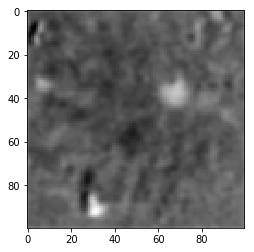

In [2]:
dataset = np.load('/home/kevinteng/Desktop//jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')
NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


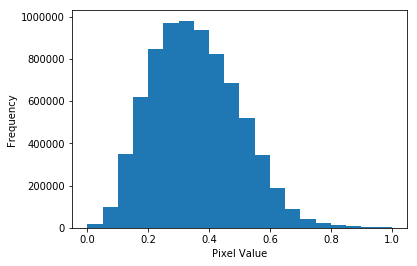

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Helper Function

In [5]:
def create_ran_numbers(img_size):
    '''
    Function to create random coordinates 
    
    @param img_size: Image size 
    
    return:
    random generated x,y coordinates 
    '''
    c1=np.random.randint(img_size, size=1)
    c2=np.random.randint(img_size, size=1)
    c1=tf.convert_to_tensor( c1,dtype=None,dtype_hint=None,name=None)
    c2=tf.convert_to_tensor( c2,dtype=None,dtype_hint=None,name=None)
    return c1,c2

@tf.function
def create_tf_tilecords(coord_list, img_size):
    o1,o2=coord_list
    multiply=tf.constant([img_size*img_size])
    y1=tf.reshape(tf.tile(o1,multiply),[img_size,img_size,1])
    y2=tf.reshape(tf.tile(o2,multiply),[img_size,img_size,1])

    y=tf.concat((y1,y2),axis=2)

    return tf.dtypes.cast(y, tf.float32),tf.dtypes.cast(coord_list, tf.float32)

@tf.function
def tf_create_onehotcords(dat):
    o1,o2=dat
    y1=tf.one_hot(o1,100)
    y2=tf.one_hot(o2,100)
    y2=tf.transpose(y2)
    y=tf.math.multiply(y1,y2)
    #y=tf.transpose(y)
    return y

def create_dat_samples(n):
    '''
    Function to create stacks of coordinates, tiled coordinates, one hot images
    @param n: number of neurons
    '''
    ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    tb = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    coords = tf.TensorArray(tf.float32, size=0, dynamic_size = True)
    for _ in tf.range(n):
        dat=create_ran_numbers(img_size=100)
        b1,b2=create_tf_tilecords(dat, 100)
        c1=tf_create_onehotcords(dat)
        c1=tf.expand_dims(c1, axis=2, name=None)
        
        #tile coordinates
        ta = ta.write(_, b1/99)  #(n, img_size, img_size, 1)
        #one hot images
        tb = tb.write(_, c1) #(n, img_size, img_size, 1)
        #coordinates
        coords = coords.write(_, dat) #(n, 2, 1)
    return coords.stack(), ta.stack(),tb.stack()

def neuron_like_image(n_neurons):
    '''
    Function to paint neuron-like images
     @param n_neurons: number of neurons
    '''
    _,_,one_hot_imgs = create_dat_samples(n_neurons)
    stack_imgs = tf.reduce_sum(one_hot_imgs, axis = 0)
    return tf.expand_dims(stack_imgs, axis = 0) #(1, img_size, img_size, 1)

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

---

# Validation

In [6]:
n_neurons = 40
img_size = 100
coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[40 1 1 2]


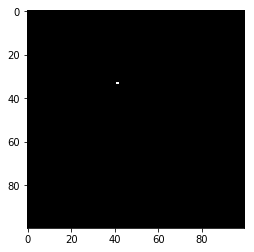

In [7]:
plt.imshow(tf.squeeze(ori_one_hot_imgs[0]), cmap = 'gray')

-----------------------------------

# Model

In [8]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers

def encoder(inps, img_size):
    #1st block
    coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 32, kernel_size = 3, padding='same')(inps)
    leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
    coord02 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky01)
    leaky02 = tf.keras.layers.LeakyReLU(0.5)(coord02)
    add01 = tf.keras.layers.Add()([leaky02, inps])
    
    #2nd block
    coord03 =  CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                      filters = 128, kernel_size = 3, padding='same')(add01)
    leaky03 = tf.keras.layers.LeakyReLU(0.5)(coord03)
    coord04 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky03)
    leaky04 = tf.keras.layers.LeakyReLU(0.5)(coord04)
    add02 = tf.keras.layers.Add()([leaky04, add01])
    
    #3rd block
    coord05 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 256, kernel_size = 3, padding='same')(add02)
    leaky05 = tf.keras.layers.LeakyReLU(0.5)(coord05)
    coord06 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky05)
    leaky06 = tf.keras.layers.LeakyReLU(0.5)(coord06)
    add03 = tf.keras.layers.Add()([leaky06, add02])

    #4th block
    coord07 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128, kernel_size = 3, padding='same')(add03)
    leaky07 = tf.keras.layers.LeakyReLU(0.5)(coord07)
    coord08 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky07)
    leaky08 = tf.keras.layers.LeakyReLU(0.5)(coord08)
    add04 =tf.keras.layers.Add()([leaky08, add03])
    
    #5th block
    coord09 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 64, kernel_size = 3, padding='same')(add04)
    leaky09 = tf.keras.layers.LeakyReLU(0.5)(coord09)
    coord10=CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky09)
    leaky10 = tf.keras.layers.LeakyReLU(0.5)(coord10)
    add05 = tf.keras.layers.Add()([leaky10, add04])
    
    #6th block
    coord11 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 32, kernel_size = 3, padding='same')(add05)
    leaky11 = tf.keras.layers.LeakyReLU(0.5)(coord11)
    coord12 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky11)
    leaky12 = tf.keras.layers.LeakyReLU(0.5)(coord12)
    add06 = tf.keras.layers.Add()([leaky12, coord11])
    output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', padding='same')(add06)
    
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
    squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def decoder(latent_dim, img_size):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_block(dense_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 64, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = coordconv_block(up_02, x_dim = img_size, y_dim = img_size, 
                              filters = 1, kernel_size = 3, strides = 1,
                              padding = 'same', activation = None)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y
    
def dataset_parse(dataset_path, NEW_SIZE):
    dataset = np.load(dataset_path)
    #re_list = dataset
    re_list = utils.resize(dataset, NEW_SIZE)
    #Dimension for network should include the color channel 
    re_list = np.expand_dims(re_list, axis = -1)
    #Cast data type to float32 for TensorFlow
    # re_list = re_list.astype('float32')
    re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
    
    return re_list

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

In [9]:
# def encoder02(inps, img_size):
#     #1st block
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same')(inps)
#     leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')(leaky01 )
#     leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [10]:
#build encoder 
inps = Input(shape=(img_size, img_size, 1))
encoder_model = Model(inps, encoder(inps, img_size))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim, img_size))

#learnable coords
l_coords = learnable_coords(coords)

In [11]:
# encoder_model.summary()

## Train Model

--------------------------------------

In [12]:
lr=0.001
opt = tf.keras.optimizers.Adam(lr)
loss_fn = tf.losses.MeanSquaredError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size):
    with tf.GradientTape() as tape:
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #output from encoder 
        encoder_output = encoder_model(inp_imgs)
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, coords, batch_size)#(batch_size, n_neurons, 3, 1)
        #reconstruction 
        reconstruction = decoder_model(latent)
        loss = loss_fn(inp_imgs, reconstruction)
        
    varis = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(loss, varis)
#     grad_coords = tape.gradient(loss, l_coords.trainable_variables)
    opt.apply_gradients(zip(grad_model, varis))
#     opt.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model 

In [13]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

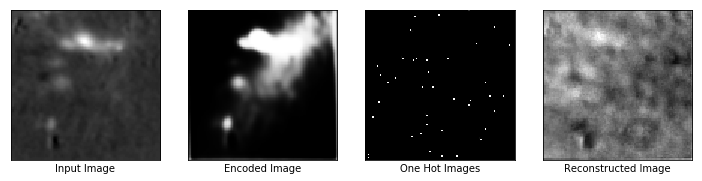

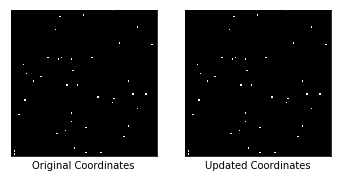

Epochs: 10, Loss: 0.0041832528077065945
Similarity scores: [1.85429025e-02 9.76629630e-02 2.47868672e-02 4.24084097e-01
 2.72537507e-02 9.35433805e-02 9.60760713e-02 1.10936806e-01
 9.54317278e-04 2.47118827e-02 1.58916935e-02 1.39357042e-04
 3.18630540e-04 1.12435311e-01 6.23653119e-04 9.97907519e-01
 3.00418109e-01 3.53517523e-03 6.25096560e-02 3.81999329e-04
 5.09814680e-01 2.12360942e-03 7.14334249e-01 6.16158962e-01
 4.55216542e-02 3.54863587e-03 1.53937921e-01 2.37591685e-05
 1.94228943e-02 2.42957706e-03 5.61128254e-04 9.91601264e-04
 3.29062110e-03 4.95089255e-02 5.56892657e-04 1.28028286e-03
 5.58014493e-03 1.20423509e-04 4.03507816e-04 2.50382163e-02]
Updated Coordinates: [[[0.41421026 0.33288088]]]
Gradient min:-0.0004732359084300697, max:0.00045991400838829577



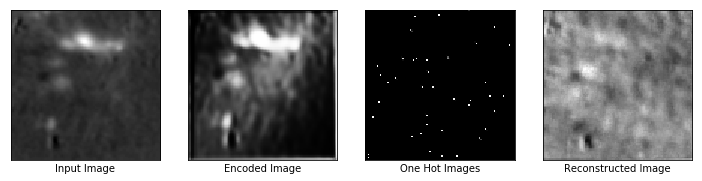

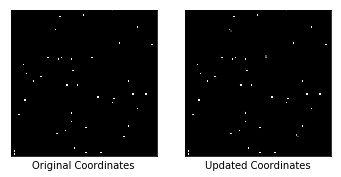

Epochs: 20, Loss: 0.004154031164944172
Similarity scores: [0.21567672 0.29187262 0.0293417  0.40884173 0.1173646  0.05588106
 0.320632   0.31186226 0.16122171 0.12262045 0.11965627 0.02495278
 0.03194147 0.2129561  0.19183803 0.80535626 0.33870548 0.07894343
 0.15751468 0.1286263  0.17917371 0.12970646 0.46999636 0.19381584
 0.38294676 0.11876506 0.11235826 0.10877592 0.23958609 0.12819709
 0.11402459 0.20043622 0.39762917 0.18291411 0.03319827 0.03691638
 0.08544552 0.11323603 0.23235933 0.21409272]
Updated Coordinates: [[[0.41356668 0.33244315]]]
Gradient min:-0.0009474458056502044, max:0.0009037079871632159



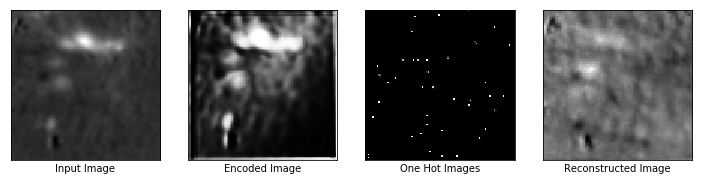

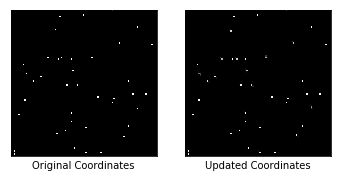

Epochs: 30, Loss: 0.004212249536067247
Similarity scores: [0.18519709 0.21658789 0.01974296 0.37250674 0.09060775 0.03164554
 0.18756172 0.18280661 0.08060191 0.0971818  0.01904042 0.01221372
 0.01849072 0.15069209 0.39514697 0.8702351  0.22857745 0.03543929
 0.14645934 0.09544033 0.12057797 0.04154217 0.39828455 0.22128189
 0.5689171  0.05382032 0.15437059 0.14659882 0.35486272 0.07752077
 0.05650186 0.16101056 0.5208154  0.11774477 0.01824391 0.02529813
 0.05680085 0.11586342 0.50657785 0.15617727]
Updated Coordinates: [[[0.41348058 0.33237353]]]
Gradient min:-0.0011702420888468623, max:0.0008118813275359571



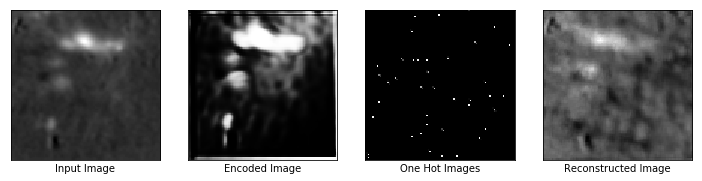

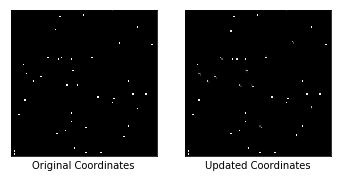

Epochs: 40, Loss: 0.0034350112546235323
Similarity scores: [0.07382584 0.09520926 0.01127302 0.3385131  0.0419695  0.01524975
 0.06024156 0.0653096  0.00779695 0.04854538 0.00096858 0.00200787
 0.00444971 0.0618201  0.56902975 0.9468684  0.14347635 0.0020871
 0.08015332 0.02880081 0.1430604  0.00985919 0.45365903 0.27815327
 0.5479784  0.01550437 0.07229675 0.04372822 0.23267233 0.01695595
 0.00690345 0.05684036 0.34353194 0.03077477 0.00480873 0.00831978
 0.02361785 0.03668042 0.4552961  0.07279116]
Updated Coordinates: [[[0.4135143  0.33240452]]]
Gradient min:-0.001204982283525169, max:0.001292755245231092



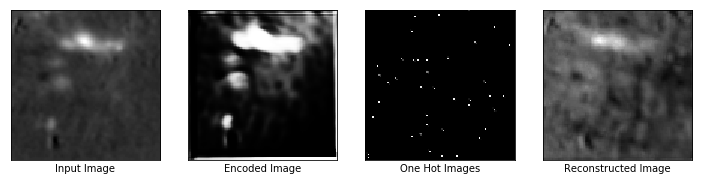

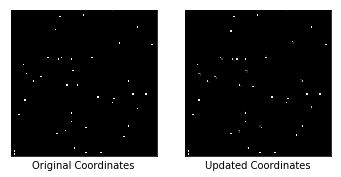

Epochs: 50, Loss: 0.003334835870191455
Similarity scores: [5.30190766e-02 6.35691211e-02 2.24442594e-02 3.53036165e-01
 2.93293390e-02 2.01522894e-02 2.94717178e-02 3.96304578e-02
 2.26136600e-03 3.52474190e-02 1.40674680e-03 1.63996359e-03
 3.41684162e-03 5.43856844e-02 5.59514582e-01 9.13867831e-01
 1.16129406e-01 9.09983879e-04 6.66818470e-02 1.91924330e-02
 1.30390912e-01 1.78840768e-03 3.62318307e-01 2.51376480e-01
 4.16539073e-01 3.54519510e-03 6.10446408e-02 2.43560597e-02
 2.06963450e-01 1.87057033e-02 6.50872011e-03 5.09343110e-02
 3.86482954e-01 2.79525984e-02 2.81831040e-03 6.55804155e-03
 1.54896015e-02 2.19642576e-02 3.02109689e-01 5.33979870e-02]
Updated Coordinates: [[[0.4140653  0.33318776]]]
Gradient min:-0.0015432260697707534, max:0.0011338255135342479



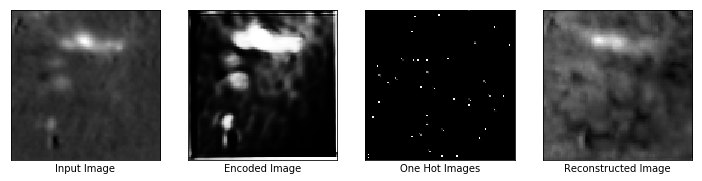

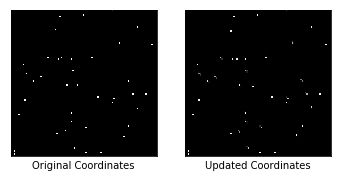

Epochs: 60, Loss: 0.0034113700967282057
Similarity scores: [0.04517844 0.10331357 0.31541708 0.48275423 0.02909883 0.02467355
 0.02837064 0.0568783  0.00593341 0.04149528 0.00164614 0.0029785
 0.00548757 0.0588334  0.46731466 0.8855833  0.09488578 0.00520695
 0.08945441 0.01392138 0.03648175 0.00194744 0.18340257 0.12269123
 0.46870643 0.00360073 0.07275703 0.02824347 0.2109     0.00984931
 0.00878282 0.04577635 0.30521208 0.05381089 0.00397787 0.00671199
 0.01685737 0.02919303 0.28405565 0.07073685]
Updated Coordinates: [[[0.41442424 0.33333838]]]
Gradient min:-0.0015409273328259587, max:0.0009141251794062555



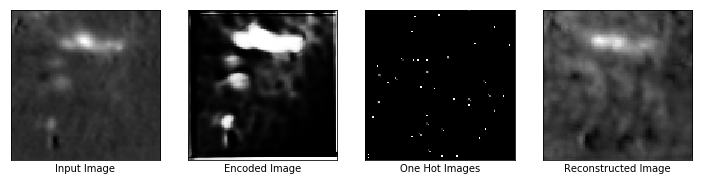

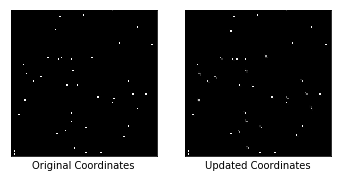

Epochs: 70, Loss: 0.0032376281451433897
Similarity scores: [2.7102342e-02 9.7910523e-02 2.9149321e-01 4.5358461e-01 2.2887792e-02
 2.6406519e-02 1.4295391e-02 5.3626355e-02 7.5245714e-03 3.1545158e-02
 2.8283582e-03 2.0207888e-03 4.0363320e-03 4.5953918e-02 4.2530984e-01
 9.6841669e-01 9.3005218e-02 4.2423415e-03 7.2317272e-02 1.3810771e-02
 2.3851393e-02 6.2122749e-04 1.0792713e-01 6.9009803e-02 5.2086937e-01
 1.0272461e-03 2.6511390e-02 1.8257389e-02 2.2028786e-01 3.1663529e-03
 1.2252090e-02 5.9939824e-02 3.3266157e-01 7.1785159e-02 2.4177718e-03
 5.1035169e-03 1.2251141e-02 2.5138019e-02 1.3708337e-01 5.1097710e-02]
Updated Coordinates: [[[0.41428563 0.33342665]]]
Gradient min:-0.0028541102074086666, max:0.0014878257643431425



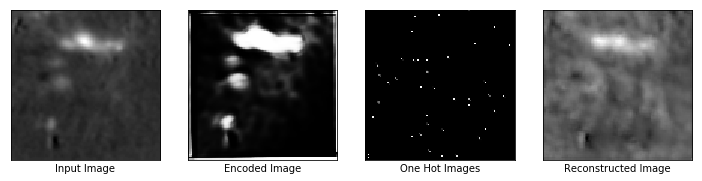

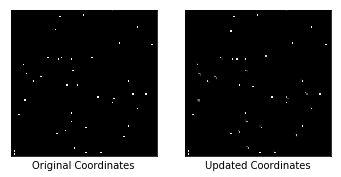

Epochs: 80, Loss: 0.003093599108979106
Similarity scores: [2.0303065e-02 7.0130192e-02 8.9616090e-01 4.4762024e-01 1.6207812e-02
 3.4654371e-02 1.4189503e-02 4.7546402e-02 8.0958037e-03 2.3776596e-02
 4.7901133e-03 1.9761783e-03 3.4381796e-03 4.2563736e-02 3.3090472e-01
 9.3221158e-01 7.6834597e-02 7.3241498e-03 7.0094213e-02 1.3897580e-02
 2.5958417e-02 1.6678084e-03 9.0389960e-02 6.4665198e-02 4.9344811e-01
 9.1822469e-04 1.2953705e-02 9.3564056e-03 1.5936597e-01 7.5262343e-04
 1.0493596e-02 4.7657497e-02 2.2448158e-01 6.4913452e-02 1.9936985e-03
 4.7886120e-03 9.3247481e-03 1.6902311e-02 5.9141997e-02 4.4692382e-02]
Updated Coordinates: [[[0.41549587 0.33327404]]]
Gradient min:-0.002717898227274418, max:0.001220090314745903



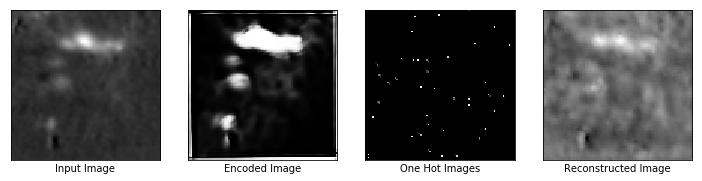

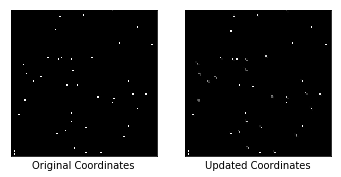

Epochs: 90, Loss: 0.004381799139082432
Similarity scores: [0.01668685 0.11004068 0.9745933  0.4486668  0.01915739 0.14454362
 0.01023267 0.053345   0.00455384 0.03508977 0.00422479 0.0037228
 0.00624692 0.0594661  0.2535204  0.8853383  0.07677689 0.0119454
 0.08933567 0.01990456 0.03786733 0.00671962 0.04249375 0.0358626
 0.4186211  0.00107279 0.00889986 0.00752037 0.14904588 0.0010527
 0.01017906 0.04841015 0.16937625 0.09882598 0.00308079 0.00638883
 0.01109414 0.01631434 0.02835874 0.06991095]
Updated Coordinates: [[[0.41945264 0.33719784]]]
Gradient min:-0.004639721009880304, max:0.0019023785134777427



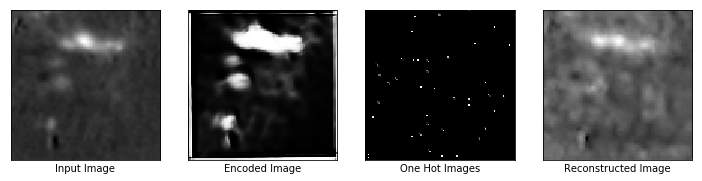

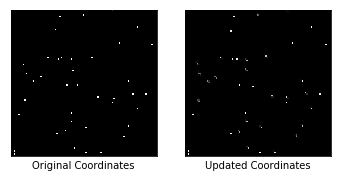

Epochs: 100, Loss: 0.0036188403610140085
Similarity scores: [2.43048780e-02 1.19445555e-01 9.99176741e-01 5.12091815e-01
 3.00088692e-02 2.56369531e-01 8.91504344e-03 5.76010346e-02
 4.45064064e-03 3.62710878e-02 4.96795541e-03 6.27913885e-03
 1.14739593e-02 8.08240473e-02 4.06866848e-01 8.09881628e-01
 9.15637165e-02 1.40266875e-02 1.12514079e-01 2.91968770e-02
 5.89949600e-02 2.84398906e-03 4.04694267e-02 3.14739011e-02
 5.73165298e-01 5.19226072e-04 2.74113729e-03 1.34405298e-02
 1.65033132e-01 7.49233738e-03 1.54803637e-02 6.83246478e-02
 2.15217426e-01 1.40863568e-01 6.22265274e-03 1.08329942e-02
 1.88862346e-02 2.78269388e-02 4.11067754e-02 9.65870991e-02]
Updated Coordinates: [[[0.4205222 0.3383548]]]
Gradient min:-0.003468884853646159, max:0.0012160761980339885



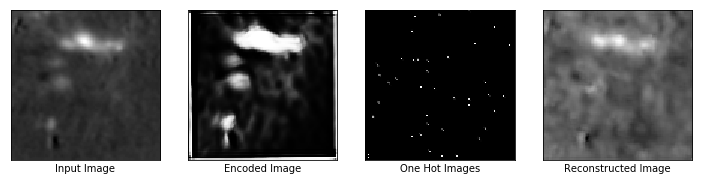

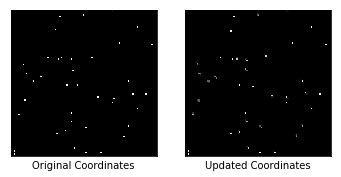

Epochs: 110, Loss: 0.003102292539551854
Similarity scores: [0.02643295 0.18986255 0.99900454 0.5000104  0.04248013 0.32435048
 0.01159081 0.07785185 0.00849883 0.05817378 0.00359711 0.00864174
 0.01795254 0.10828875 0.385025   0.80446726 0.07019371 0.01977572
 0.15068206 0.03285019 0.05023557 0.0037865  0.04595532 0.03867847
 0.5475981  0.00112689 0.00434971 0.03388874 0.2575742  0.00289757
 0.01274329 0.07611372 0.19333884 0.16142495 0.00748009 0.01127174
 0.02092615 0.04629    0.0972148  0.13237253]
Updated Coordinates: [[[0.4208013  0.33856565]]]
Gradient min:-0.002876582555472851, max:0.0009560506441630423



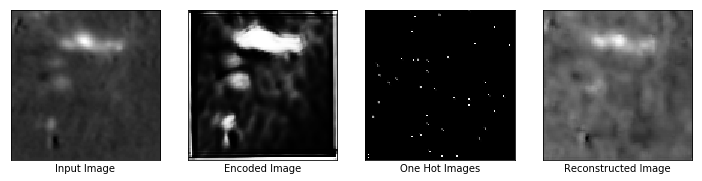

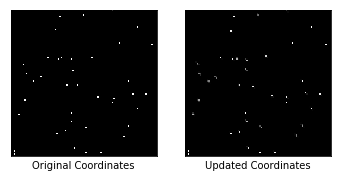

Epochs: 120, Loss: 0.0025295987725257874
Similarity scores: [0.0335653  0.17779984 0.98190343 0.54915446 0.05111944 0.03740497
 0.02423111 0.06454489 0.01022979 0.06855373 0.00420244 0.01040039
 0.02035345 0.11072725 0.45882687 0.8118273  0.08128875 0.01692555
 0.17206852 0.02919165 0.08242562 0.0058622  0.06284332 0.06675202
 0.5437075  0.0018637  0.00324427 0.03440854 0.2978544  0.00508614
 0.01598396 0.07046685 0.1698966  0.1499388  0.00786682 0.01579642
 0.02654749 0.05905553 0.14977346 0.12682703]
Updated Coordinates: [[[0.420433   0.33831444]]]
Gradient min:-0.0012330291792750359, max:0.0003394993836991489



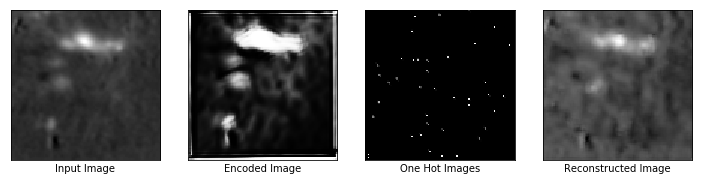

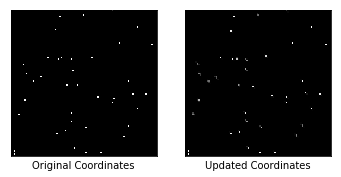

Epochs: 130, Loss: 0.0023458595387637615
Similarity scores: [0.04671181 0.19853538 0.82428753 0.49853945 0.06577003 0.00624467
 0.03446309 0.06968278 0.01766918 0.08715907 0.00417911 0.01499981
 0.02941598 0.12736519 0.48659343 0.78847027 0.09110924 0.01021516
 0.17481922 0.04342978 0.19754201 0.00633503 0.05555318 0.0906022
 0.5404668  0.00234537 0.00236703 0.03751287 0.3339684  0.01956589
 0.01783418 0.10426182 0.21965146 0.16414791 0.01751204 0.03136356
 0.0385076  0.06059233 0.2016312  0.14336036]
Updated Coordinates: [[[0.41979533 0.3375608 ]]]
Gradient min:-0.001023118500597775, max:0.00032526772702112794



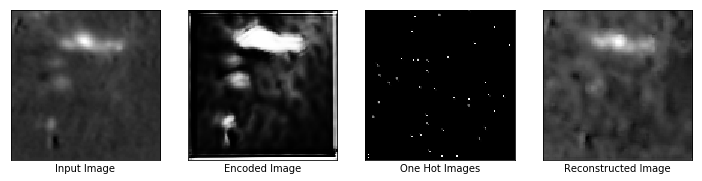

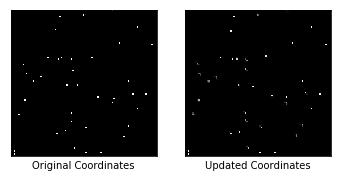

Epochs: 140, Loss: 0.0020969691686332226
Similarity scores: [0.04082324 0.15115803 0.1848097  0.40034488 0.08834457 0.00119406
 0.02692951 0.06515127 0.01051274 0.08119612 0.00403099 0.01526617
 0.03321411 0.11870675 0.49562448 0.8554034  0.08383015 0.0052246
 0.17378627 0.03758325 0.314785   0.00360498 0.08279905 0.13066655
 0.4873152  0.00325589 0.00170772 0.0234576  0.27271008 0.0140119
 0.00995053 0.07842024 0.19332904 0.10209564 0.01863635 0.02983284
 0.05256992 0.03992179 0.17363858 0.11355016]
Updated Coordinates: [[[0.4199198  0.33771104]]]
Gradient min:-0.0011336260940879583, max:0.00027432289789430797



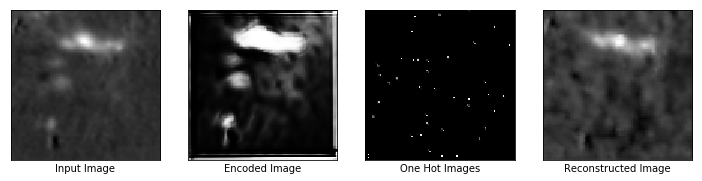

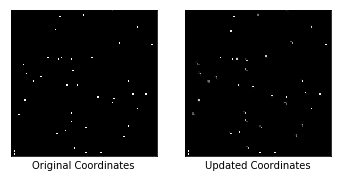

Epochs: 150, Loss: 0.003501993604004383
Similarity scores: [3.2876536e-02 1.5929091e-01 2.3222767e-02 4.1777638e-01 9.0405002e-02
 9.2356838e-04 2.3772005e-02 6.8563960e-02 7.6015620e-03 7.5717159e-02
 2.5538290e-03 1.4942486e-02 3.1219978e-02 1.1556181e-01 4.6443665e-01
 9.4785321e-01 8.0848284e-02 2.7631656e-03 1.8097225e-01 2.6825016e-02
 4.3444279e-01 3.3964498e-03 1.1302999e-01 2.2353220e-01 4.2138249e-01
 3.2538469e-03 2.9784252e-03 1.6412890e-02 2.2486928e-01 1.0888246e-02
 6.6206688e-03 5.9545152e-02 1.7073083e-01 7.6415069e-02 2.5920434e-02
 4.7731388e-02 5.0852410e-02 2.5175173e-02 1.3616967e-01 1.0970906e-01]
Updated Coordinates: [[[0.42068517 0.33867893]]]
Gradient min:-0.005538668949157, max:0.0013482002541422844



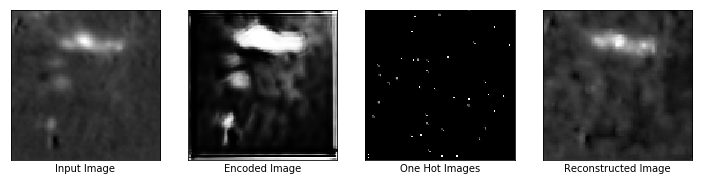

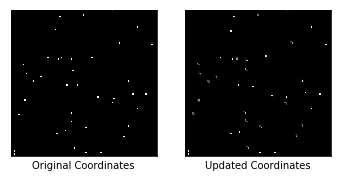

Epochs: 160, Loss: 0.002500019036233425
Similarity scores: [0.03973779 0.15604693 0.05603404 0.44934466 0.10919235 0.00360921
 0.03947518 0.10250768 0.01074573 0.08495243 0.00429605 0.02202276
 0.04210425 0.12557407 0.48240578 0.9523649  0.09797119 0.00578968
 0.2420354  0.04408975 0.46210843 0.00516607 0.07642929 0.2562949
 0.46063715 0.00548446 0.00413968 0.02350886 0.19844438 0.01871623
 0.0102837  0.06818987 0.16004686 0.09020884 0.03780095 0.03847059
 0.0671303  0.03667596 0.12684023 0.12608393]
Updated Coordinates: [[[0.42071688 0.33872938]]]
Gradient min:-0.0030381781980395317, max:0.0004997364012524486



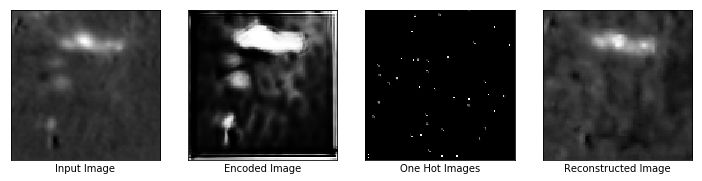

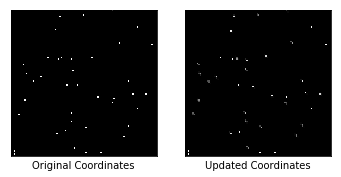

Epochs: 170, Loss: 0.0025139017961919308
Similarity scores: [0.03856578 0.18462119 0.01923252 0.46230286 0.09974637 0.00211644
 0.04386559 0.08847601 0.01367387 0.08614073 0.00252095 0.01926536
 0.04115217 0.12808914 0.49665233 0.9458928  0.08113308 0.00424959
 0.2197398  0.03879556 0.52990925 0.00841627 0.06763963 0.2226806
 0.45358685 0.00845331 0.00708628 0.02840083 0.22602148 0.03104724
 0.01367688 0.07698195 0.15022811 0.10961545 0.03152781 0.03379212
 0.06214384 0.04324831 0.14826962 0.14122888]
Updated Coordinates: [[[0.42085633 0.33891705]]]
Gradient min:-0.0030911797657608986, max:0.0006505539058707654



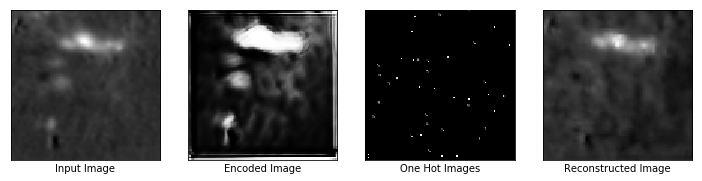

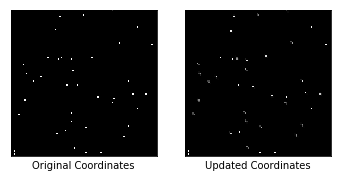

Epochs: 180, Loss: 0.002295225625857711
Similarity scores: [0.0469925  0.19009529 0.02249849 0.46080232 0.11043847 0.00246512
 0.04735535 0.08744286 0.02136571 0.10721325 0.005142   0.02858261
 0.05020737 0.13883916 0.50590765 0.9429253  0.10584833 0.00645563
 0.24354923 0.05185419 0.50907916 0.01333106 0.09198248 0.21695417
 0.44179764 0.01467891 0.00724448 0.03417711 0.24905734 0.03051834
 0.01822076 0.09106149 0.18272494 0.12770377 0.04589668 0.05365134
 0.07481381 0.05164751 0.14499696 0.1487475 ]
Updated Coordinates: [[[0.42101026 0.3392101 ]]]
Gradient min:-0.0026022675447165966, max:0.0004001692868769169



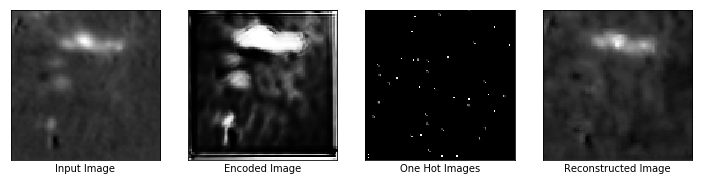

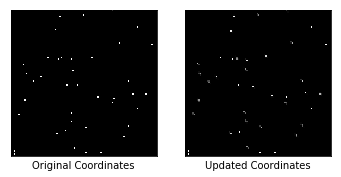

Epochs: 190, Loss: 0.002465356606990099
Similarity scores: [0.04587412 0.21450551 0.05680754 0.46050093 0.10765167 0.00240173
 0.05858745 0.10459317 0.02569144 0.09422028 0.00272174 0.02221617
 0.04829837 0.13616693 0.53455454 0.95120394 0.09060162 0.00565632
 0.24359977 0.05566407 0.47342646 0.00962592 0.08023793 0.16263841
 0.502448   0.01096501 0.00534469 0.03968753 0.26436102 0.04263343
 0.01760115 0.101817   0.22116624 0.12479368 0.03993767 0.03760021
 0.07123868 0.06065092 0.16223519 0.14310233]
Updated Coordinates: [[[0.4210642  0.33931434]]]
Gradient min:-0.0032383413054049015, max:0.0005332913715392351



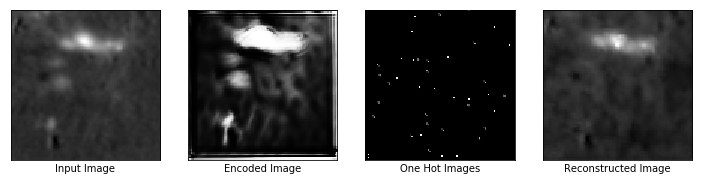

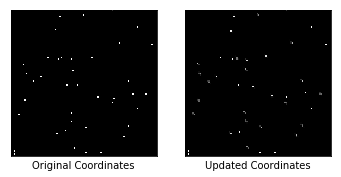

Epochs: 200, Loss: 0.002086538588628173
Similarity scores: [0.05115931 0.2097532  0.07720227 0.42815855 0.11720601 0.00149793
 0.05706055 0.10820308 0.03349581 0.09613959 0.00486392 0.02863162
 0.0586667  0.13290636 0.6073063  0.94519466 0.1161246  0.00462998
 0.21220848 0.05771322 0.48520112 0.01165887 0.06580115 0.19743533
 0.4594637  0.00925754 0.00298747 0.04530485 0.26225156 0.03633819
 0.02095275 0.11858547 0.20432235 0.10876001 0.03784661 0.03678769
 0.07575954 0.06567258 0.22664748 0.14786814]
Updated Coordinates: [[[0.42074743 0.3388234 ]]]
Gradient min:-0.0024943260941654444, max:0.0007644484285265207



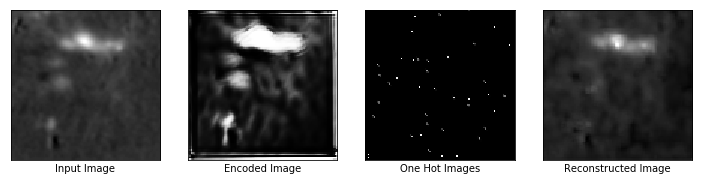

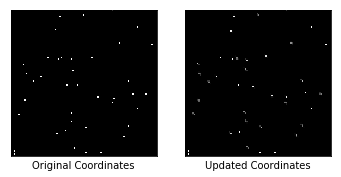

Epochs: 210, Loss: 0.002050623530521989
Similarity scores: [0.04587332 0.22009863 0.09356192 0.5369363  0.08681412 0.00138645
 0.05299761 0.11451928 0.02929398 0.08034785 0.00416717 0.01996229
 0.03961023 0.1242825  0.5723104  0.9515119  0.08452798 0.00542399
 0.19171248 0.04893085 0.37885574 0.00222347 0.06553514 0.1400254
 0.53011614 0.00320591 0.00147584 0.05835238 0.32928723 0.02548677
 0.0247451  0.14566882 0.26824883 0.11401119 0.02447748 0.01808685
 0.05297768 0.095818   0.2430456  0.14466572]
Updated Coordinates: [[[0.42069188 0.33866957]]]
Gradient min:-0.001873235683888197, max:0.0008560029091313481



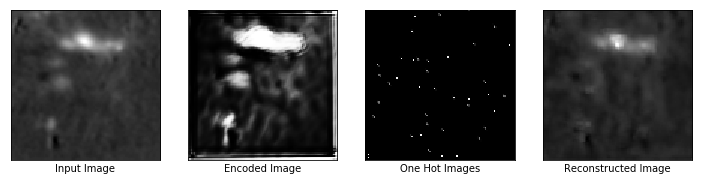

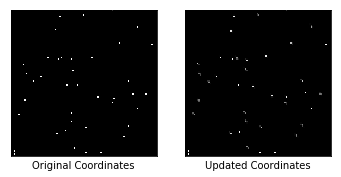

Epochs: 220, Loss: 0.0016930393176153302
Similarity scores: [3.96212786e-02 2.85028070e-01 8.18025023e-02 4.85615373e-01
 1.15042560e-01 6.43582898e-04 4.83640470e-02 1.20717645e-01
 2.09682751e-02 1.10846385e-01 3.66402254e-03 3.39117758e-02
 6.70816675e-02 1.40774652e-01 5.13417780e-01 9.44735646e-01
 9.28492546e-02 8.05194490e-03 2.55497724e-01 4.64328118e-02
 4.94631439e-01 2.68026516e-02 8.00862312e-02 1.69747666e-01
 5.98291576e-01 5.52085899e-02 1.90526701e-03 3.78401130e-02
 3.08670431e-01 5.24969213e-03 1.82635766e-02 1.09503873e-01
 2.36897111e-01 1.39516875e-01 4.00372371e-02 5.26845753e-02
 8.06873590e-02 7.65566528e-02 1.47674561e-01 1.85529739e-01]
Updated Coordinates: [[[0.42123824 0.3389269 ]]]
Gradient min:-0.0010919601190835238, max:0.00020150920317973942



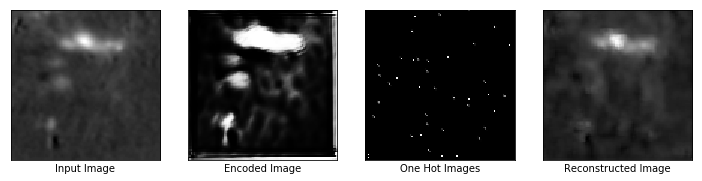

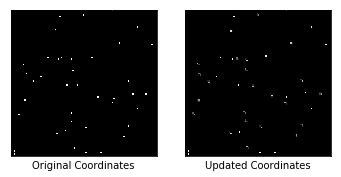

Epochs: 230, Loss: 0.0027477096300572157
Similarity scores: [1.2803847e-02 2.0612124e-01 1.6048887e-01 5.2204823e-01 5.3831674e-02
 7.1448053e-04 1.2482517e-02 6.0852338e-02 1.0845361e-02 5.4919098e-02
 1.4750984e-03 1.1756768e-02 2.6976481e-02 8.4469937e-02 5.1875734e-01
 9.4786608e-01 5.1281437e-02 3.6800813e-03 1.8690868e-01 7.9959081e-03
 4.7066578e-01 2.5461337e-02 3.0342946e-02 5.8512326e-02 6.3719791e-01
 1.6134698e-02 2.7675503e-03 1.7881911e-02 2.1409565e-01 2.0797244e-04
 5.8722682e-03 5.5598676e-02 1.6493037e-01 1.0945094e-01 1.3641889e-02
 1.0619154e-02 3.1991296e-02 3.6161803e-02 6.5357879e-02 1.1817867e-01]
Updated Coordinates: [[[0.4212043  0.33883545]]]
Gradient min:-0.0042396895587444305, max:0.0004961435915902257



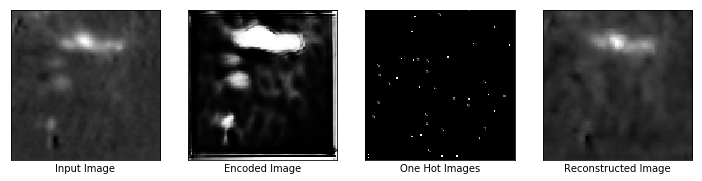

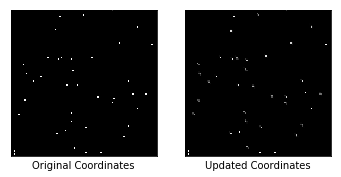

Epochs: 240, Loss: 0.0029971019830554724
Similarity scores: [1.1398067e-02 1.2694350e-01 4.8692614e-01 4.7729868e-01 3.7981551e-02
 8.5678855e-03 2.2091098e-02 4.8783120e-02 1.0703639e-02 3.5312153e-02
 2.4406849e-03 5.5148723e-03 1.2663570e-02 6.1098088e-02 6.4287311e-01
 9.6160579e-01 5.2238360e-02 5.8649405e-04 1.2569338e-01 2.0037292e-02
 3.3992159e-01 2.9723926e-03 3.2025438e-02 4.8933428e-02 5.5279076e-01
 3.9677392e-03 2.2434779e-03 2.5388261e-02 2.0341523e-01 1.0711043e-03
 8.6372839e-03 8.8775523e-02 1.9266595e-01 7.4258804e-02 5.8654719e-03
 7.8003514e-03 1.9175384e-02 4.6609413e-02 1.7127573e-01 7.9863600e-02]
Updated Coordinates: [[[0.42084908 0.33846942]]]
Gradient min:-0.005449086893349886, max:0.0010398798622190952



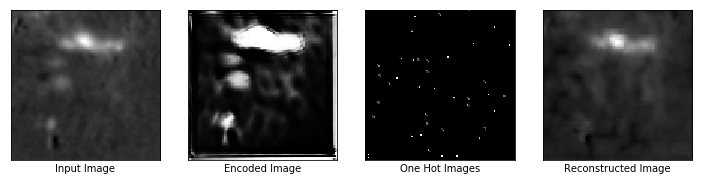

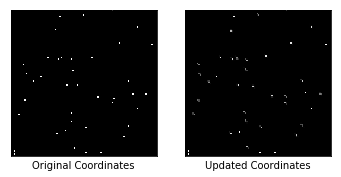

Epochs: 250, Loss: 0.002625127322971821
Similarity scores: [2.0760482e-02 1.3512962e-01 1.9297235e-01 5.1677597e-01 4.6119362e-02
 7.3228078e-03 2.6003309e-02 6.5431416e-02 1.8091196e-02 4.0808834e-02
 4.2078812e-03 7.3990677e-03 1.7108275e-02 8.0289312e-02 6.0063106e-01
 9.5554858e-01 7.6978877e-02 7.8997784e-04 1.6216661e-01 2.5274700e-02
 2.9150432e-01 4.6404460e-03 4.5727078e-02 4.8600495e-02 5.7893068e-01
 8.9680869e-03 3.8523211e-03 4.1089039e-02 3.2343435e-01 1.1593414e-03
 1.4394993e-02 1.0657621e-01 2.7317593e-01 7.3660471e-02 7.3063164e-03
 8.0392398e-03 2.4341967e-02 8.2620695e-02 1.7032357e-01 8.1539452e-02]
Updated Coordinates: [[[0.42007932 0.3380083 ]]]
Gradient min:-0.004460052587091923, max:0.0007677386165596545



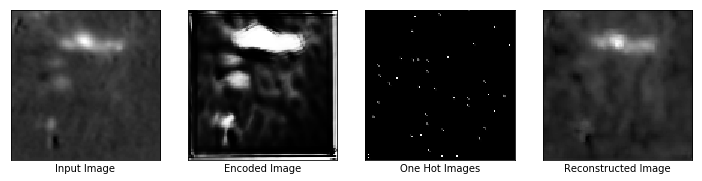

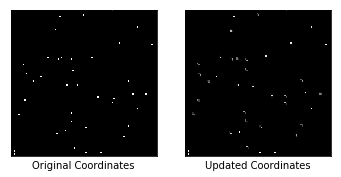

Epochs: 260, Loss: 0.0021008127368986607
Similarity scores: [0.02634946 0.16313139 0.24514917 0.48313493 0.05181339 0.00870127
 0.04257848 0.07490291 0.02981022 0.04785585 0.0102981  0.00830942
 0.0199894  0.0931683  0.5689294  0.9297423  0.09447052 0.00164774
 0.17698394 0.02033381 0.3622925  0.01172884 0.05798867 0.05872045
 0.5827331  0.02710194 0.0050932  0.04836332 0.33555874 0.00199664
 0.02223115 0.16891383 0.29766378 0.07664192 0.00886617 0.01230459
 0.02920219 0.10098146 0.16740444 0.08680288]
Updated Coordinates: [[[0.42016616 0.33783343]]]
Gradient min:-0.0032693916000425816, max:0.0006158234318718314



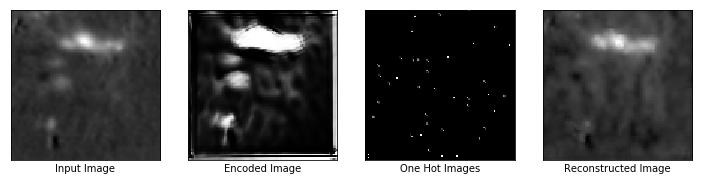

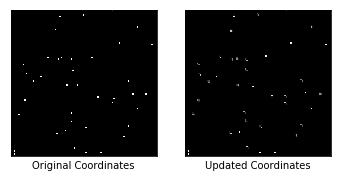

Epochs: 270, Loss: 0.0019066119566559792
Similarity scores: [0.03011658 0.17995228 0.31617975 0.46974632 0.05684298 0.01091689
 0.06223425 0.09730389 0.03852174 0.05016177 0.01939673 0.01098257
 0.02420449 0.09988006 0.60624844 0.8978108  0.10048775 0.00214079
 0.1936167  0.02565805 0.39149916 0.00437278 0.08295718 0.06150238
 0.5569485  0.00943982 0.00497496 0.05629062 0.28466186 0.00215879
 0.03075807 0.16957788 0.3097243  0.08622325 0.01068108 0.01826739
 0.03284222 0.11559258 0.18850923 0.10053743]
Updated Coordinates: [[[0.4202685 0.3379464]]]
Gradient min:-0.0022909773979336023, max:0.0006812262581661344



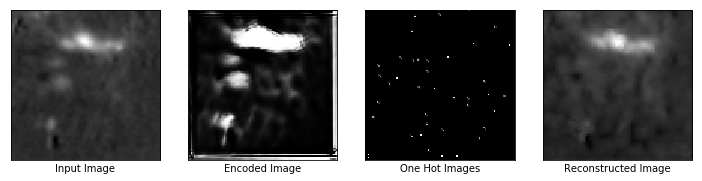

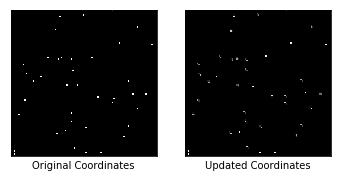

Epochs: 280, Loss: 0.0018846862949430943
Similarity scores: [1.6421286e-02 1.4010422e-01 3.6599192e-01 4.2656738e-01 4.3002270e-02
 1.2769969e-02 3.1356174e-02 7.8901224e-02 3.5303794e-02 3.5288859e-02
 1.9945510e-02 9.2460550e-03 1.9548453e-02 8.3573043e-02 6.3080597e-01
 8.7399012e-01 9.5280208e-02 1.6797758e-03 1.9979756e-01 2.4080157e-02
 3.7876335e-01 1.1881634e-02 3.0921139e-02 3.8566999e-02 5.0364864e-01
 3.0576359e-02 9.1175800e-03 4.3405272e-02 1.7626363e-01 6.2422530e-04
 2.0243933e-02 1.6442619e-01 2.5896692e-01 8.8563323e-02 8.3908709e-03
 8.6622862e-03 2.4383359e-02 9.2132613e-02 1.0433370e-01 9.1276988e-02]
Updated Coordinates: [[[0.42021775 0.33812946]]]
Gradient min:-0.0015926194610074162, max:0.0007504422683268785



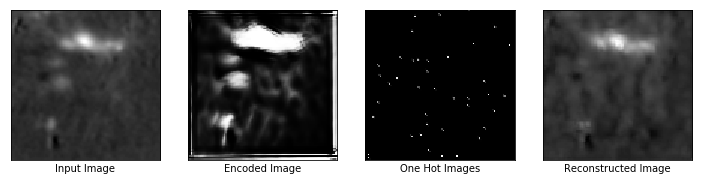

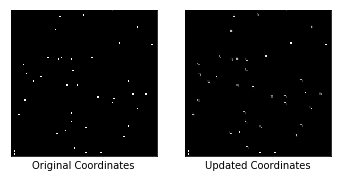

Epochs: 290, Loss: 0.001656675129197538
Similarity scores: [0.01956762 0.18931131 0.7099547  0.4586034  0.05458929 0.01759451
 0.05527465 0.12339547 0.04708266 0.041215   0.02685423 0.01420608
 0.02771377 0.08413875 0.6093989  0.9210127  0.10580162 0.00373902
 0.23157014 0.05540415 0.44883743 0.01081422 0.03867684 0.04315474
 0.4630022  0.02596598 0.00755821 0.05694306 0.19823419 0.00152829
 0.02938049 0.20446369 0.29976267 0.11154958 0.01377367 0.00962883
 0.03276653 0.10348853 0.11963492 0.11935335]
Updated Coordinates: [[[0.42049775 0.3385683 ]]]
Gradient min:-0.001545588718727231, max:0.0010656943777576089



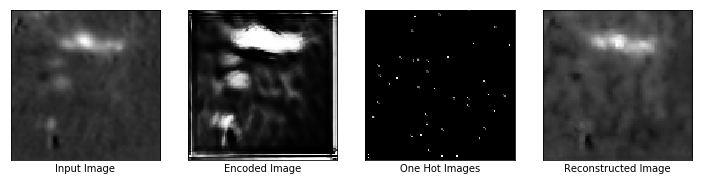

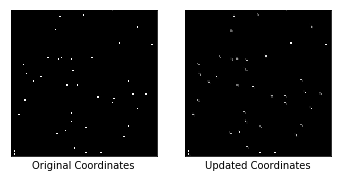

Epochs: 300, Loss: 0.0016567058628425002
Similarity scores: [0.02871814 0.18351223 0.8454038  0.502285   0.05635591 0.03427265
 0.06456839 0.13490747 0.07974468 0.04441545 0.04853963 0.01520106
 0.02823158 0.10020791 0.6147669  0.93996954 0.12536435 0.01190526
 0.18239997 0.06009374 0.25140917 0.00738075 0.13944866 0.03760133
 0.46219137 0.02607775 0.00212726 0.0740687  0.23750281 0.00315073
 0.04063751 0.25126943 0.2829846  0.11772721 0.0122383  0.00875402
 0.03288786 0.13279614 0.17997085 0.11647656]
Updated Coordinates: [[[0.42064375 0.33853936]]]
Gradient min:-0.0005909952451474965, max:0.0005579249118454754



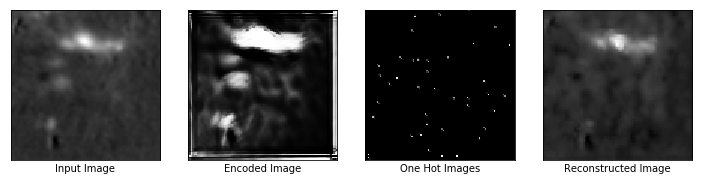

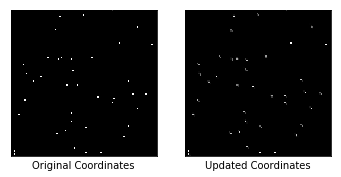

Epochs: 310, Loss: 0.0016598720103502274
Similarity scores: [0.03828564 0.2264574  0.8941004  0.50021243 0.0592518  0.02179258
 0.08153854 0.16398941 0.10280241 0.05579092 0.04608842 0.0231503
 0.03924118 0.11280391 0.5850844  0.9491159  0.13851888 0.02159609
 0.19640586 0.07898495 0.24220458 0.02489595 0.04015495 0.02580402
 0.47194836 0.05754729 0.00265119 0.09297372 0.24861029 0.00303112
 0.05994113 0.27972308 0.3480915  0.16445102 0.01895513 0.01388907
 0.04195576 0.16518773 0.16738012 0.15696014]
Updated Coordinates: [[[0.42053774 0.33841103]]]
Gradient min:-0.00010853054118342698, max:0.000618919322732836



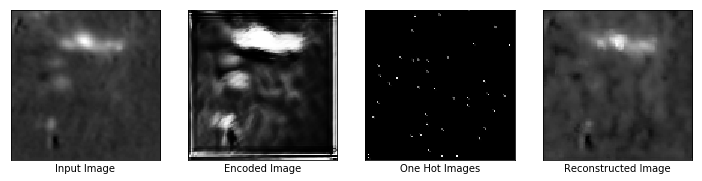

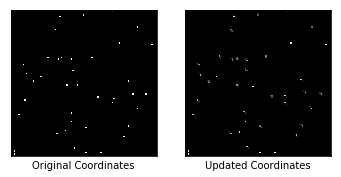

Epochs: 320, Loss: 0.002189618768170476
Similarity scores: [0.04876368 0.305892   0.8858199  0.5285643  0.08456776 0.01606224
 0.11332378 0.19206353 0.10472756 0.08669964 0.04881946 0.04271528
 0.06451046 0.14319141 0.54847306 0.9462605  0.16946708 0.04625759
 0.24024682 0.09238779 0.24105762 0.025665   0.10875414 0.04311198
 0.486656   0.10563913 0.00742154 0.10683299 0.2390238  0.00326999
 0.07070812 0.28294018 0.29572892 0.24194339 0.03627612 0.02795595
 0.0615991  0.19312793 0.15264212 0.20645477]
Updated Coordinates: [[[0.42053974 0.3380819 ]]]
Gradient min:-0.000959149794653058, max:0.0030814060010015965



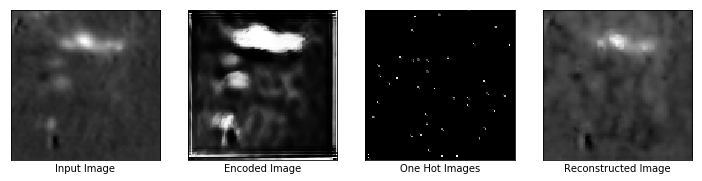

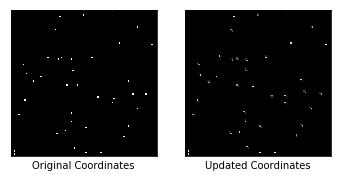

Epochs: 330, Loss: 0.002518358174711466
Similarity scores: [0.02675672 0.268058   0.8220391  0.50160736 0.06970178 0.0079761
 0.0783492  0.18710956 0.12489536 0.07128898 0.03396229 0.04334842
 0.05987933 0.12843296 0.5037743  0.96335906 0.14157519 0.06033555
 0.23013388 0.06044376 0.22006127 0.0434927  0.0143588  0.03249594
 0.46202388 0.10659254 0.00165048 0.07703499 0.15179247 0.00219668
 0.05879323 0.28221092 0.24328598 0.21910505 0.03305702 0.01130934
 0.04873699 0.14159013 0.11397731 0.19815195]
Updated Coordinates: [[[0.42030162 0.33780712]]]
Gradient min:-0.0007788735092617571, max:0.0022060757037252188



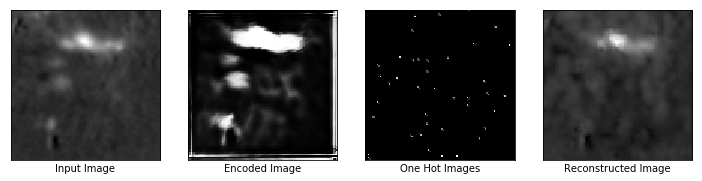

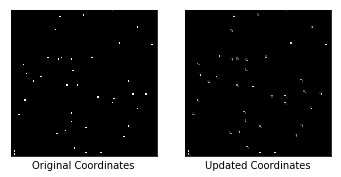

Epochs: 340, Loss: 0.0017581493593752384
Similarity scores: [0.01338536 0.16067521 0.8657483  0.4535416  0.04470726 0.01764951
 0.03660898 0.1334032  0.06538277 0.04521619 0.02879204 0.02041245
 0.03603406 0.09024252 0.5485894  0.9703049  0.11434199 0.01172797
 0.22156587 0.06048914 0.4246462  0.02822694 0.02650139 0.01610151
 0.4448862  0.07185479 0.00411521 0.03770089 0.11192443 0.00117387
 0.02949106 0.22959484 0.22843152 0.14302954 0.01706851 0.00778749
 0.03009394 0.08099328 0.04879279 0.1353563 ]
Updated Coordinates: [[[0.42113662 0.33780825]]]
Gradient min:-0.0006298618391156197, max:0.0003225396212656051



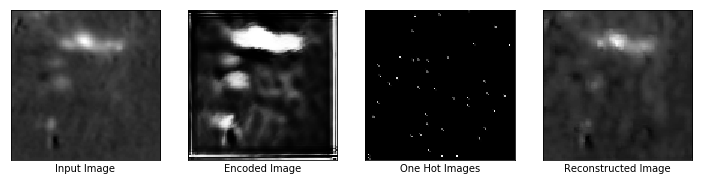

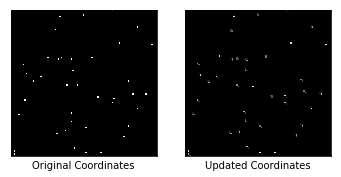

Epochs: 350, Loss: 0.0016846690559759736
Similarity scores: [0.02959545 0.23197238 0.74708647 0.51173156 0.07647398 0.02673099
 0.07335953 0.17389469 0.10900494 0.07676131 0.05348408 0.03941761
 0.06503667 0.12884532 0.5882515  0.9498274  0.16507012 0.02557566
 0.2644286  0.06967751 0.37214053 0.08185066 0.03454573 0.04909035
 0.4535512  0.14116038 0.00746538 0.07295839 0.16044824 0.00293334
 0.05850358 0.25396925 0.29100257 0.21910222 0.0320015  0.02798209
 0.05550279 0.13963613 0.10277504 0.18623433]
Updated Coordinates: [[[0.42104512 0.3378227 ]]]
Gradient min:-0.0004035962629131973, max:0.0013306119944900274



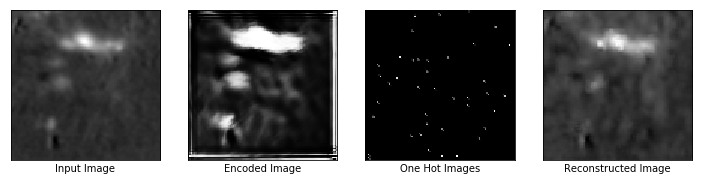

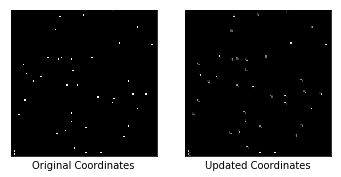

Epochs: 360, Loss: 0.0015012988587841392
Similarity scores: [0.03319241 0.23609287 0.7021091  0.5178124  0.07917308 0.03431737
 0.07857253 0.1718912  0.11788575 0.07999289 0.06230994 0.03847643
 0.06572902 0.13085182 0.61460656 0.9251958  0.17685072 0.03058135
 0.25858784 0.09603044 0.42446992 0.06914549 0.06628539 0.04903586
 0.45923528 0.1324838  0.00769649 0.08487301 0.17388625 0.00422231
 0.06892151 0.27653965 0.30717987 0.21199106 0.03211426 0.03016934
 0.05543659 0.15603939 0.13566037 0.18549412]
Updated Coordinates: [[[0.4210571  0.33803523]]]
Gradient min:-0.0003374270745553076, max:0.0001719402353046462



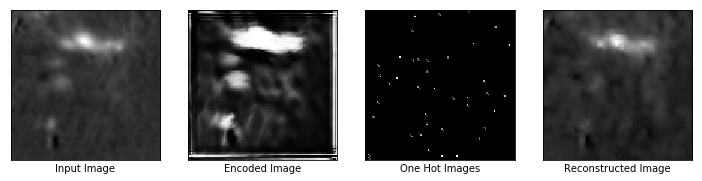

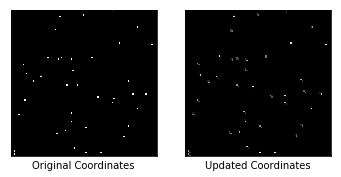

Epochs: 370, Loss: 0.001497514545917511
Similarity scores: [0.03816497 0.22822466 0.65165526 0.5243332  0.08096425 0.02824522
 0.08508363 0.16174632 0.11106649 0.08342414 0.04787252 0.03874155
 0.06572655 0.13541937 0.622936   0.9148748  0.15624188 0.03225463
 0.27195993 0.1113096  0.41148332 0.05521265 0.10686455 0.04578267
 0.47150934 0.13188949 0.00564282 0.09341159 0.17830154 0.00726349
 0.06656722 0.26380205 0.29560915 0.21005437 0.03412973 0.03014833
 0.05826324 0.15661739 0.16851981 0.18508667]
Updated Coordinates: [[[0.42121637 0.33820003]]]
Gradient min:-0.0009810203919187188, max:0.00029684469336643815



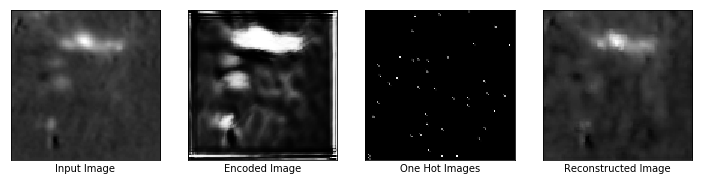

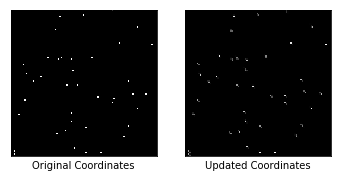

Epochs: 380, Loss: 0.0014195152325555682
Similarity scores: [0.02688619 0.2118244  0.62218237 0.52653587 0.07398587 0.01109556
 0.06434606 0.13379632 0.09248959 0.0783031  0.05614703 0.03542716
 0.06091715 0.1305831  0.61567235 0.92554957 0.15557842 0.0296908
 0.25498283 0.08096717 0.48838496 0.07048289 0.09002142 0.05065868
 0.47174445 0.14384048 0.02889894 0.07987291 0.14646342 0.00275425
 0.06066952 0.23742692 0.27036366 0.20366454 0.03122277 0.03193692
 0.05070724 0.13555688 0.15973325 0.17956166]
Updated Coordinates: [[[0.42157197 0.33832553]]]
Gradient min:-0.0002599504659883678, max:0.00037104557850398123



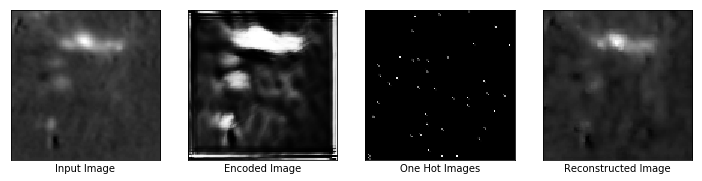

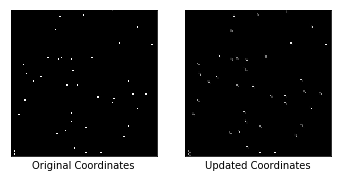

Epochs: 390, Loss: 0.0013337143464013934
Similarity scores: [0.02839222 0.2521594  0.5913466  0.540178   0.07045904 0.0155888
 0.05624102 0.1340668  0.10908857 0.07832401 0.0515679  0.03297739
 0.05744982 0.12622793 0.61917895 0.9070343  0.15288013 0.03126332
 0.23987247 0.0789576  0.46741778 0.07806892 0.09154122 0.02814861
 0.50023323 0.17052224 0.02918932 0.07932869 0.16990545 0.0022515
 0.06328903 0.27514198 0.26773164 0.18999538 0.02626795 0.02822288
 0.04689792 0.13737892 0.18934393 0.20552537]
Updated Coordinates: [[[0.42161652 0.33841246]]]
Gradient min:-0.0009098867885768414, max:0.000511963851749897



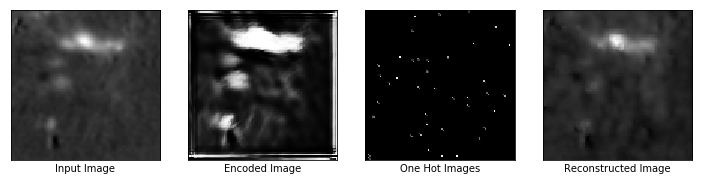

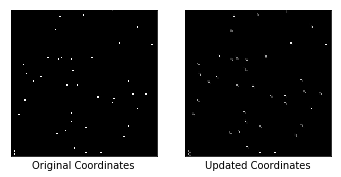

Epochs: 400, Loss: 0.0015362869016826153
Similarity scores: [0.02592035 0.21080945 0.56004006 0.572589   0.06342775 0.01147526
 0.06264731 0.13165943 0.08789232 0.06984311 0.0626873  0.03172289
 0.05345025 0.12534098 0.58619946 0.92531425 0.14807308 0.02758512
 0.2312506  0.07483989 0.46833554 0.02143415 0.07016472 0.03085076
 0.4785587  0.07406959 0.01081562 0.07188525 0.16005464 0.00577549
 0.05961574 0.25389248 0.26575363 0.1877515  0.02272732 0.02200804
 0.04335629 0.12212665 0.12124394 0.1708869 ]
Updated Coordinates: [[[0.4214572  0.33809048]]]
Gradient min:-0.0016522660152986646, max:0.0005478184903040528



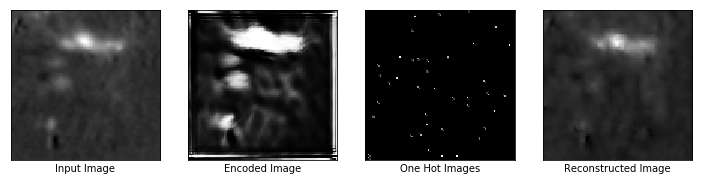

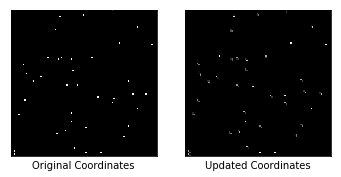

Epochs: 410, Loss: 0.001241450197994709
Similarity scores: [0.02256111 0.22100972 0.45466992 0.55489206 0.06725709 0.00540135
 0.04800589 0.12148608 0.07977811 0.0700217  0.04777437 0.03006551
 0.0538502  0.13327889 0.5925592  0.9544031  0.15462339 0.02823999
 0.24709553 0.06298255 0.65379214 0.04828136 0.17186868 0.02726823
 0.5403911  0.11315976 0.01498192 0.06462896 0.16167066 0.00147529
 0.04569832 0.2275651  0.25483602 0.21266997 0.02397013 0.02000281
 0.04759373 0.10986934 0.18573399 0.16977343]
Updated Coordinates: [[[0.42127544 0.33856565]]]
Gradient min:-6.420786667149514e-05, max:0.000257979758316651



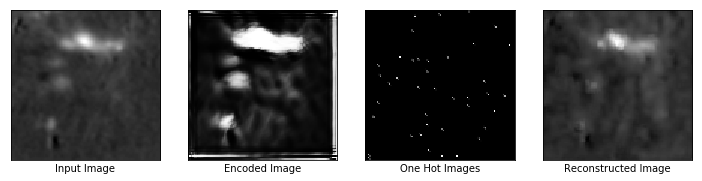

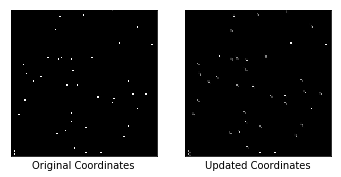

Epochs: 420, Loss: 0.0019082275684922934
Similarity scores: [0.02127186 0.23977326 0.47254485 0.4922407  0.07416692 0.00643373
 0.03921596 0.12821299 0.06138853 0.07266105 0.03379094 0.03459065
 0.05646526 0.12375127 0.4454972  0.9634648  0.13385896 0.03219307
 0.25254962 0.05240832 0.5208549  0.05821916 0.10972698 0.03063022
 0.4833241  0.12054455 0.01385023 0.03750786 0.10433532 0.00168427
 0.03017973 0.16514972 0.16337025 0.17265417 0.02899717 0.02930758
 0.05230578 0.070165   0.13430594 0.18290412]
Updated Coordinates: [[[0.42133406 0.33879042]]]
Gradient min:-0.001628874451853335, max:5.974429222987965e-05



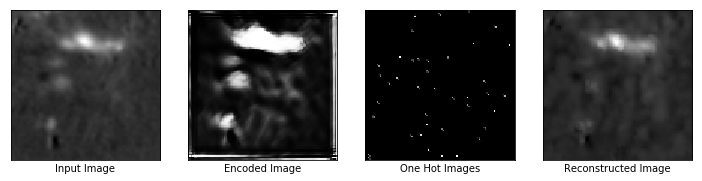

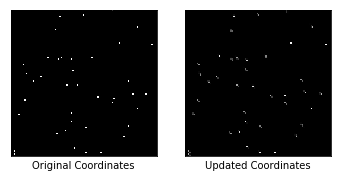

Epochs: 430, Loss: 0.0016440562903881073
Similarity scores: [2.1031313e-02 2.1801516e-01 4.6611205e-01 5.0974190e-01 7.7101894e-02
 9.1513488e-03 3.3261102e-02 1.3406020e-01 5.1577397e-02 7.1059145e-02
 2.2990635e-02 3.5713751e-02 6.5931946e-02 1.2126334e-01 5.8189654e-01
 9.7843677e-01 1.2923081e-01 2.3215203e-02 2.5641498e-01 3.6737636e-02
 4.5853189e-01 7.5142570e-02 4.2665869e-02 4.2804301e-02 4.5262331e-01
 1.8906361e-01 3.5214823e-02 3.3433869e-02 1.4321320e-01 8.0185838e-04
 3.0452553e-02 1.8623501e-01 1.6705287e-01 1.7401527e-01 2.6803967e-02
 3.0243948e-02 5.5979580e-02 6.0717378e-02 9.1042913e-02 1.7189878e-01]
Updated Coordinates: [[[0.4212047 0.3385786]]]
Gradient min:-0.0014485846040770411, max:0.00012667592091020197



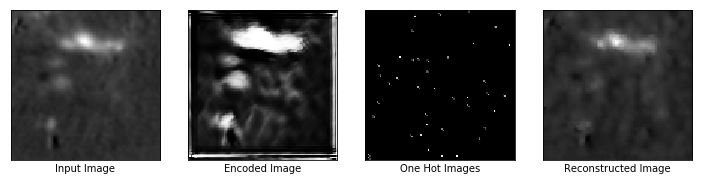

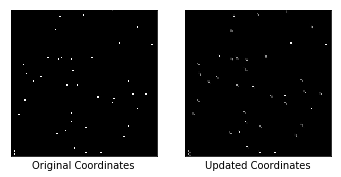

Epochs: 440, Loss: 0.001643573516048491
Similarity scores: [0.02474306 0.22401252 0.4817746  0.5762204  0.08416425 0.00559155
 0.04705597 0.15222834 0.06495617 0.0814402  0.03545807 0.04534284
 0.07556473 0.13629419 0.57202375 0.95087016 0.14041534 0.01418062
 0.2955774  0.09529577 0.6215892  0.03464738 0.0635246  0.04840979
 0.49427032 0.07648384 0.01645766 0.06362206 0.15011306 0.00296157
 0.04494465 0.22742833 0.28902537 0.20515878 0.03997031 0.04288786
 0.06465542 0.0899938  0.06127929 0.19311474]
Updated Coordinates: [[[0.42179105 0.3381982 ]]]
Gradient min:-0.001423810375854373, max:0.0015906409826129675



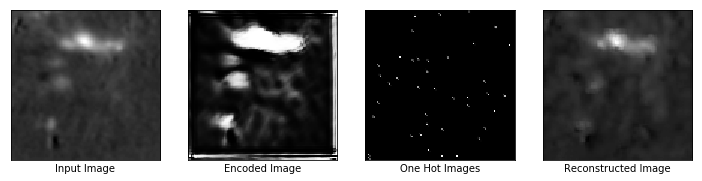

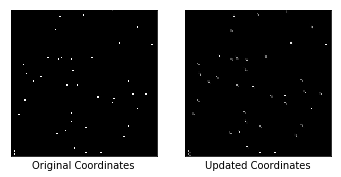

Epochs: 450, Loss: 0.0013474024599418044
Similarity scores: [0.01605422 0.19119105 0.1959668  0.5260345  0.06241841 0.01366188
 0.03931055 0.11291149 0.05026951 0.06350922 0.03320709 0.02274192
 0.04710518 0.10917743 0.5208756  0.9877883  0.13110967 0.00495333
 0.26467744 0.05304732 0.5596791  0.0213925  0.04805194 0.04126341
 0.4348057  0.06930949 0.01852295 0.02999199 0.12374372 0.00109729
 0.02912965 0.18237033 0.23068348 0.14197084 0.01942136 0.01777519
 0.04575564 0.05928917 0.0888521  0.17100155]
Updated Coordinates: [[[0.42183906 0.33833888]]]
Gradient min:-0.0008488267776556313, max:9.958550072042271e-05



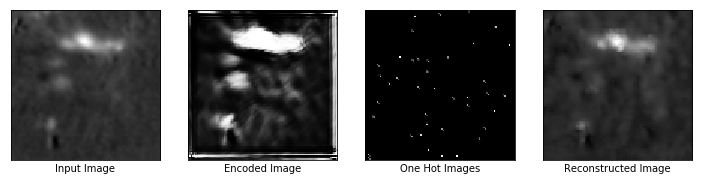

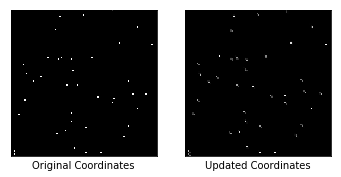

Epochs: 460, Loss: 0.0012650397839024663
Similarity scores: [0.03198187 0.24879768 0.3897734  0.57836056 0.0931353  0.0116686
 0.0723227  0.14903292 0.07768381 0.09841953 0.06071659 0.04109389
 0.08028521 0.14452925 0.53225714 0.9589527  0.16620372 0.01659789
 0.32506612 0.0923929  0.6012761  0.03985518 0.09528348 0.04132724
 0.51169664 0.10982823 0.01852745 0.05271178 0.1798626  0.00272334
 0.04082435 0.22675677 0.24721594 0.19022031 0.03642768 0.03774022
 0.07257117 0.09476805 0.12604862 0.20905714]
Updated Coordinates: [[[0.4216534 0.3380898]]]
Gradient min:-0.0006649482529610395, max:0.0002203489129897207



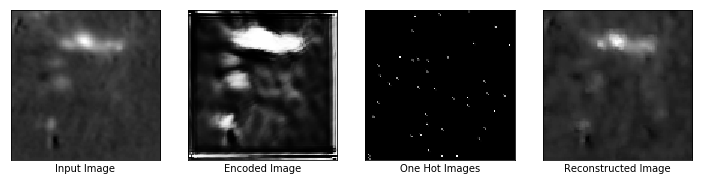

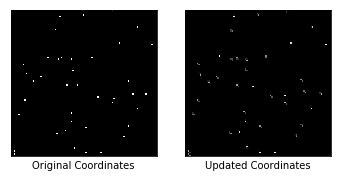

Epochs: 470, Loss: 0.001156228594481945
Similarity scores: [0.03038286 0.223135   0.4223184  0.5506756  0.08833172 0.01777673
 0.06139126 0.15480429 0.08906884 0.08774325 0.06363729 0.04353569
 0.0773478  0.13474119 0.56022036 0.960608   0.18406072 0.01413649
 0.29802707 0.09584314 0.55222905 0.031923   0.08779741 0.04712689
 0.4923891  0.11783105 0.02340075 0.05334515 0.15734011 0.00250631
 0.05457287 0.23300378 0.20993942 0.19512753 0.03828022 0.03484716
 0.06808681 0.09600278 0.14709315 0.20101655]
Updated Coordinates: [[[0.42148694 0.3380205 ]]]
Gradient min:-0.0004335148842073977, max:0.0004153212357778102



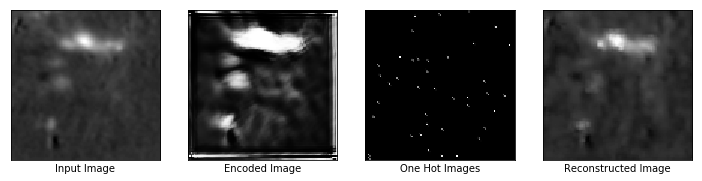

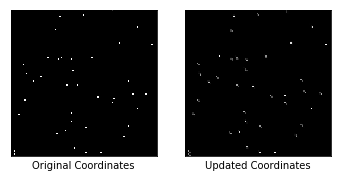

Epochs: 480, Loss: 0.001104614813812077
Similarity scores: [0.03275568 0.2430764  0.48184925 0.5562508  0.09110536 0.01347575
 0.07259604 0.1562116  0.07887682 0.09518326 0.05634354 0.04639208
 0.07768084 0.13175347 0.52427834 0.9478252  0.18296947 0.01899308
 0.29531828 0.10160965 0.5481565  0.02788963 0.09175825 0.05691062
 0.50869787 0.10381068 0.02234573 0.05826333 0.15638131 0.0031092
 0.05981144 0.22570719 0.21484642 0.20135127 0.03930024 0.04241713
 0.06805842 0.10324594 0.16592517 0.20678502]
Updated Coordinates: [[[0.4213959 0.3379485]]]
Gradient min:-0.0006197842885740101, max:6.328227027552202e-05



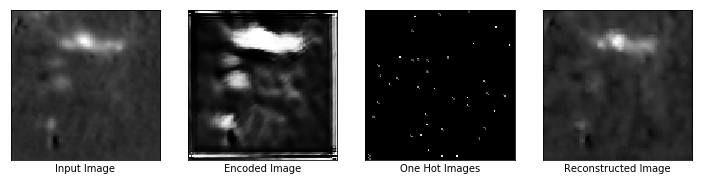

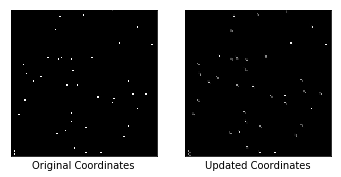

Epochs: 490, Loss: 0.0011729617835953832
Similarity scores: [0.03043584 0.24624538 0.46625826 0.5251155  0.09048277 0.01068972
 0.07159146 0.13824624 0.06931674 0.09164975 0.0486753  0.04910002
 0.08290484 0.12940092 0.5443481  0.92525417 0.1642873  0.02828429
 0.27409115 0.09447906 0.5741068  0.04026062 0.08117716 0.0504456
 0.47150207 0.12045272 0.01497576 0.04688136 0.14773479 0.00203467
 0.05238091 0.20720033 0.1753632  0.20836194 0.03818063 0.03855705
 0.07023901 0.08658099 0.14238282 0.20043817]
Updated Coordinates: [[[0.42110693 0.33778614]]]
Gradient min:-0.0008037418592721224, max:8.277864253614098e-05



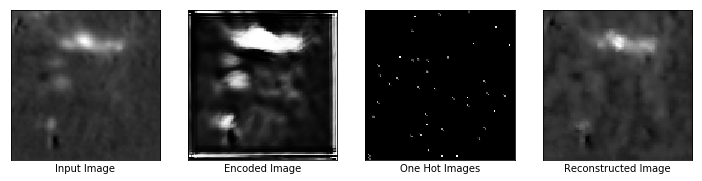

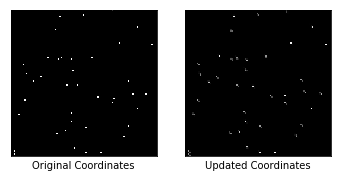

Epochs: 500, Loss: 0.0013781634625047445
Similarity scores: [0.02721424 0.20559283 0.4278929  0.5099051  0.07548518 0.00415046
 0.04862233 0.1412584  0.07069857 0.08384244 0.05146832 0.05024221
 0.06944714 0.13031523 0.5358717  0.9282775  0.15134233 0.01868589
 0.2599015  0.09847491 0.619311   0.03387146 0.08278642 0.03830256
 0.40570372 0.13340448 0.02191445 0.05641867 0.13797423 0.00267326
 0.05728298 0.20366693 0.21654776 0.18807134 0.03830937 0.04448803
 0.05984758 0.0941746  0.15087338 0.19118302]
Updated Coordinates: [[[0.42115337 0.3380526 ]]]
Gradient min:-0.0009231491712853312, max:0.000743769749533385



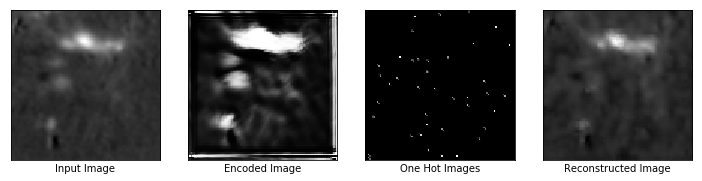

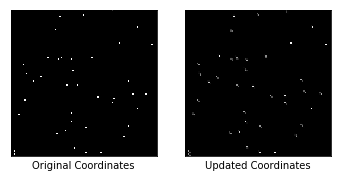

Epochs: 510, Loss: 0.0011201282031834126
Similarity scores: [0.02443143 0.20043762 0.42688274 0.5211657  0.07474799 0.01850185
 0.05277385 0.13082133 0.06084186 0.0766982  0.04493909 0.03624068
 0.06600614 0.1214603  0.6033513  0.93725395 0.16348012 0.01082081
 0.26297718 0.11132898 0.65637636 0.00994561 0.06793126 0.0320171
 0.47936505 0.06879125 0.01008046 0.05945362 0.16032346 0.0022208
 0.05323319 0.22259894 0.21445346 0.18391882 0.02731595 0.03295361
 0.05477937 0.09754442 0.19393396 0.18507947]
Updated Coordinates: [[[0.42130777 0.3379852 ]]]
Gradient min:-0.0003305870632175356, max:4.3118459871038795e-05



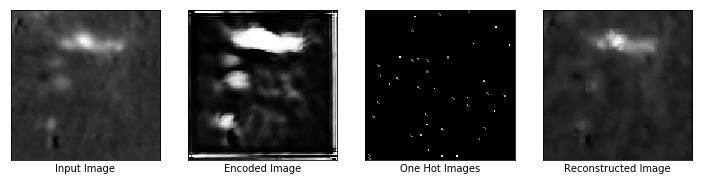

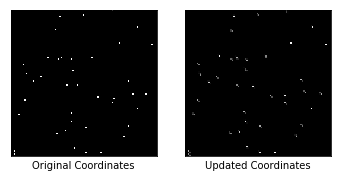

Epochs: 520, Loss: 0.0022479859180748463
Similarity scores: [0.01471005 0.1831797  0.3826884  0.497116   0.05753193 0.02206359
 0.04072949 0.10600328 0.04767775 0.05735028 0.02148427 0.02435564
 0.05079933 0.09495333 0.52252257 0.955725   0.11227069 0.00685904
 0.23661073 0.07084057 0.5920245  0.02651143 0.07718685 0.01988062
 0.49964747 0.09166978 0.01051291 0.03272884 0.13872479 0.00106757
 0.03158506 0.17411965 0.22273141 0.16355032 0.01771538 0.01640864
 0.04095979 0.07006143 0.12917341 0.15655194]
Updated Coordinates: [[[0.42101988 0.33788565]]]
Gradient min:-0.0038704134058207273, max:0.0011133382795378566



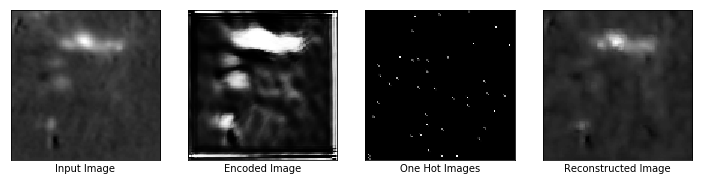

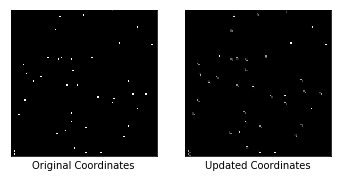

Epochs: 530, Loss: 0.001139522180892527
Similarity scores: [0.02069391 0.197901   0.3895361  0.54179    0.0812531  0.01048985
 0.0398588  0.15007111 0.05130951 0.07566956 0.06070244 0.04013776
 0.07478528 0.13028361 0.5222464  0.96665823 0.17085062 0.01560751
 0.29408443 0.08461669 0.7727843  0.02676116 0.10994978 0.04398567
 0.4925979  0.09444008 0.01470724 0.04765513 0.11243603 0.00109299
 0.0465181  0.22523814 0.23294002 0.19332576 0.02804482 0.0331042
 0.05791753 0.08623662 0.14049108 0.18520235]
Updated Coordinates: [[[0.4206452  0.33757943]]]
Gradient min:-0.0006913435063324869, max:5.706374940928072e-05



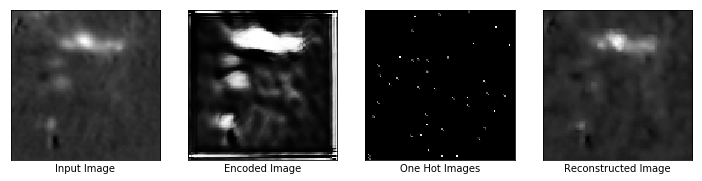

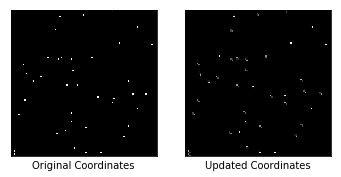

Epochs: 540, Loss: 0.0013140484225004911
Similarity scores: [2.2946196e-02 1.9069298e-01 3.8924059e-01 5.3528094e-01 7.3958807e-02
 1.7275687e-02 4.4992257e-02 1.4185612e-01 5.2783024e-02 6.9893874e-02
 5.4535933e-02 3.2931983e-02 6.5416493e-02 1.1935349e-01 5.1407820e-01
 9.7067988e-01 1.5027882e-01 1.3867384e-02 2.8983423e-01 8.0315351e-02
 7.7256972e-01 3.2048702e-02 1.0446905e-01 3.8456433e-02 5.1558536e-01
 1.1646924e-01 6.7786104e-03 4.1212317e-02 1.5865883e-01 3.8413802e-04
 4.1344769e-02 2.2150843e-01 2.2625978e-01 1.6999775e-01 2.4659010e-02
 2.2444507e-02 5.2409887e-02 7.5194739e-02 1.0756024e-01 1.8542887e-01]
Updated Coordinates: [[[0.4207657  0.33772802]]]
Gradient min:-0.0012857350520789623, max:0.00012530115782283247



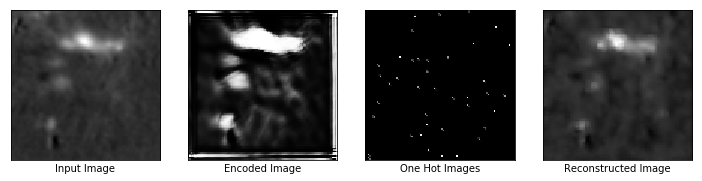

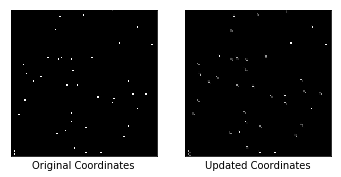

Epochs: 550, Loss: 0.0013108710991218686
Similarity scores: [1.89549327e-02 1.94896191e-01 4.53679323e-01 6.11635506e-01
 6.40300885e-02 1.80723444e-02 3.74512412e-02 1.41497016e-01
 4.71747965e-02 7.05817118e-02 5.32023497e-02 2.85522863e-02
 5.81561103e-02 1.24527842e-01 4.17332053e-01 9.75461364e-01
 1.54862255e-01 8.26390553e-03 2.90152609e-01 7.14735240e-02
 7.54580915e-01 1.81571078e-02 8.73394012e-02 2.57935803e-02
 5.34587681e-01 8.45272094e-02 1.64262112e-02 4.29104902e-02
 1.17010236e-01 2.00555020e-04 4.66912761e-02 2.29581743e-01
 2.45097071e-01 1.73961192e-01 1.98511872e-02 1.53485099e-02
 4.42587659e-02 7.88202211e-02 8.65748972e-02 1.91206783e-01]
Updated Coordinates: [[[0.42077267 0.33779076]]]
Gradient min:-0.0011217143619433045, max:0.0005393189494498074



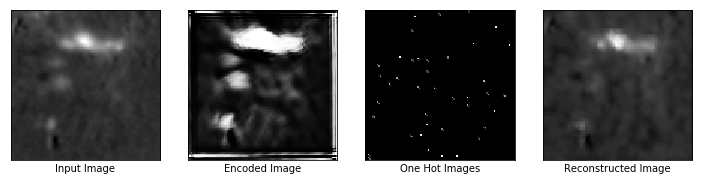

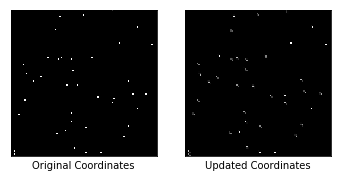

Epochs: 560, Loss: 0.0012392615899443626
Similarity scores: [0.02852301 0.19618458 0.4220158  0.5499214  0.07526037 0.00578048
 0.06042556 0.12782384 0.04254394 0.0797096  0.03705439 0.03674695
 0.06481558 0.13938227 0.48259193 0.956412   0.15288197 0.01536301
 0.26917997 0.11929872 0.7858381  0.02709174 0.08497367 0.04076647
 0.50309205 0.10724721 0.00970097 0.05440036 0.1623809  0.00203931
 0.03800575 0.19717237 0.27627835 0.16880074 0.0315813  0.04057462
 0.05582302 0.09580092 0.12151409 0.183676  ]
Updated Coordinates: [[[0.42039084 0.33772227]]]
Gradient min:-0.0017357070464640856, max:0.0004250953788869083



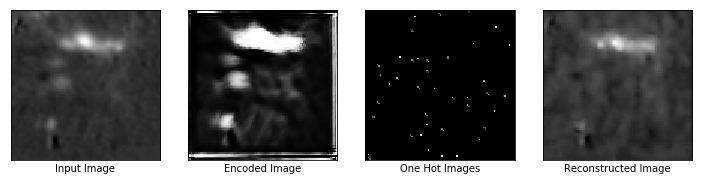

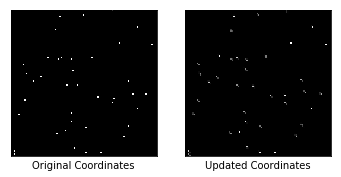

Epochs: 570, Loss: 0.0019883301574736834
Similarity scores: [1.6866919e-02 2.2374786e-01 5.3855956e-01 4.7318843e-01 6.3034199e-02
 7.5430665e-03 5.7360590e-02 1.1503418e-01 5.1446922e-02 6.5575592e-02
 3.2015391e-02 3.2867055e-02 5.4342791e-02 1.1626657e-01 5.2747858e-01
 9.7467041e-01 1.2303164e-01 1.7992517e-02 2.2776403e-01 8.1865773e-02
 5.7541287e-01 1.9150509e-02 4.4254109e-02 2.9957848e-02 3.5424194e-01
 7.5487636e-02 5.4494743e-03 3.6379039e-02 1.4055768e-01 5.6256063e-04
 3.2493047e-02 1.7007922e-01 2.1240832e-01 1.5199952e-01 2.7538151e-02
 3.3854455e-02 4.9761452e-02 6.7152984e-02 8.6797364e-02 1.6049716e-01]
Updated Coordinates: [[[0.42080483 0.33774865]]]
Gradient min:-0.0030932542867958546, max:0.0008748352993279696



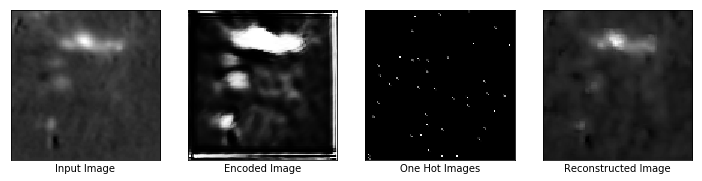

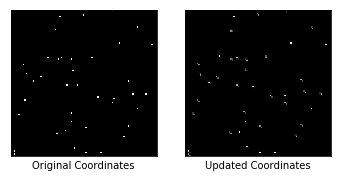

Epochs: 580, Loss: 0.0013682289281859994
Similarity scores: [0.01846333 0.17000602 0.08532558 0.5598856  0.06675007 0.00375366
 0.0317875  0.10913316 0.03987137 0.06137657 0.03146762 0.02820044
 0.05233463 0.11534713 0.6111664  0.98662406 0.13114662 0.00333426
 0.27975747 0.07053189 0.7630216  0.02073384 0.05080467 0.05761129
 0.4115702  0.06242672 0.00989967 0.03399382 0.08846164 0.00110333
 0.03052693 0.17293489 0.24561632 0.1258924  0.02968294 0.0310346
 0.0520721  0.06430154 0.10070638 0.1530643 ]
Updated Coordinates: [[[0.4213367  0.33782053]]]
Gradient min:-0.0014753886498510838, max:0.0008215216221287847



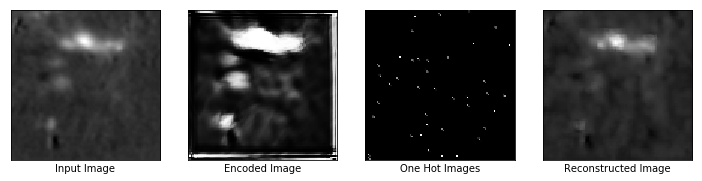

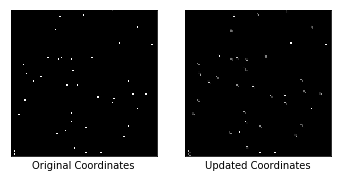

Epochs: 590, Loss: 0.001152802025899291
Similarity scores: [0.02615732 0.21418904 0.2539456  0.54656875 0.07334047 0.00676992
 0.06182282 0.14288765 0.06953123 0.07529209 0.05055444 0.03960397
 0.06567322 0.13564229 0.5981935  0.9645997  0.1549469  0.009441
 0.2837655  0.11797617 0.7243658  0.03556191 0.05916473 0.05106458
 0.4575098  0.09012847 0.00911677 0.06339765 0.12917933 0.00426371
 0.05071508 0.23468915 0.28056324 0.17164543 0.0373366  0.04070497
 0.06005777 0.10405547 0.15489686 0.18949242]
Updated Coordinates: [[[0.42118812 0.33791018]]]
Gradient min:-0.0009793555364012718, max:0.00017965200822800398



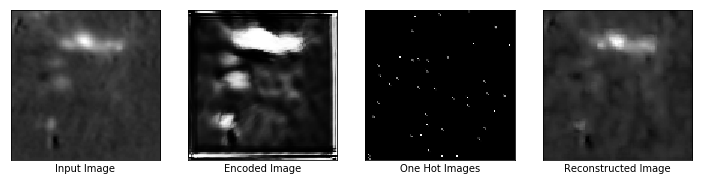

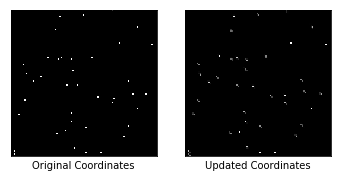

Epochs: 600, Loss: 0.0011080139083787799
Similarity scores: [0.03064308 0.19880715 0.3549204  0.5368938  0.07581516 0.00759406
 0.05462394 0.14916556 0.07456762 0.08224938 0.04930814 0.04181062
 0.07004482 0.13361247 0.5938262  0.9572183  0.16128531 0.01106097
 0.28326848 0.13371976 0.71896005 0.0395617  0.06546495 0.04551212
 0.4658488  0.10364927 0.01245851 0.0673302  0.14441    0.00240875
 0.05698834 0.23500736 0.27061814 0.1719203  0.03866673 0.04650678
 0.06216254 0.11007874 0.17128454 0.19333306]
Updated Coordinates: [[[0.4210814  0.33789065]]]
Gradient min:-0.000660027377307415, max:0.00014147146430332214



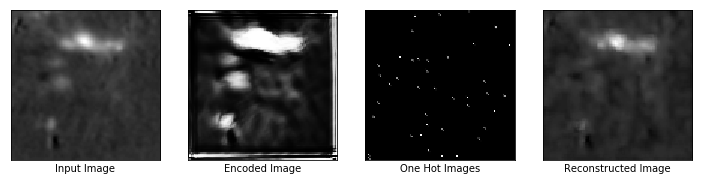

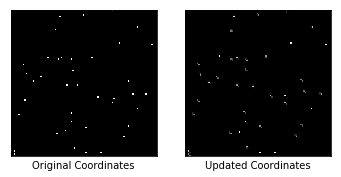

Epochs: 610, Loss: 0.0010729813948273659
Similarity scores: [0.02782824 0.22104266 0.42464915 0.54253536 0.07597104 0.01094241
 0.06103427 0.16196088 0.06254497 0.08587987 0.05378562 0.03807745
 0.06980649 0.13840441 0.58529687 0.93948644 0.17439261 0.01461759
 0.28027484 0.12231008 0.7029878  0.03229726 0.05320842 0.0474522
 0.46119615 0.08799093 0.01292279 0.06655353 0.14233562 0.00299893
 0.06079498 0.24057296 0.2580371  0.17760396 0.03351279 0.0434519
 0.05485267 0.10896137 0.12955643 0.20043062]
Updated Coordinates: [[[0.42084467 0.33781606]]]
Gradient min:-0.0006526301731355488, max:5.834594412590377e-05



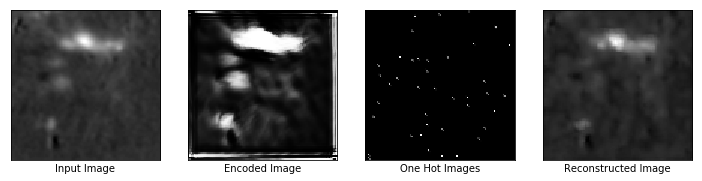

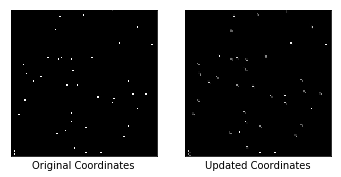

Epochs: 620, Loss: 0.0015842100838199258
Similarity scores: [0.02293686 0.19308886 0.50560546 0.56664675 0.06415485 0.01032351
 0.0557566  0.15052377 0.06467179 0.07080977 0.05266057 0.03216092
 0.05987302 0.12643126 0.51754737 0.96309906 0.15834124 0.01022281
 0.25568902 0.12343264 0.6425325  0.02281845 0.08603658 0.03063924
 0.4760672  0.06037753 0.0133785  0.06014811 0.15725438 0.00218017
 0.05224696 0.23933625 0.31558326 0.16901055 0.02294806 0.03269227
 0.0444835  0.1046731  0.11669943 0.17984548]
Updated Coordinates: [[[0.4208062 0.3378372]]]
Gradient min:-0.0023251341190189123, max:0.000703715137206018



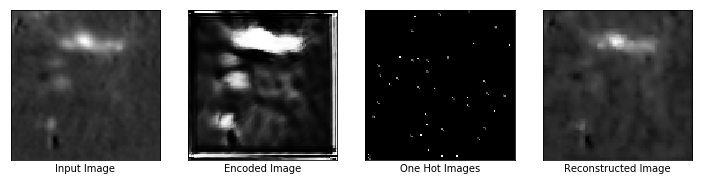

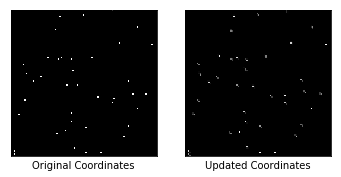

Epochs: 630, Loss: 0.0012388600734993815
Similarity scores: [0.02585852 0.22749256 0.42421538 0.5541145  0.07113031 0.00709159
 0.05633094 0.1772221  0.08203571 0.09022222 0.05862671 0.04328414
 0.07554458 0.14917076 0.58396196 0.95618343 0.17613897 0.01056956
 0.29749942 0.13535604 0.7938399  0.0407078  0.0663394  0.03186602
 0.4049243  0.10069741 0.00400374 0.06680541 0.104857   0.00163952
 0.06380617 0.2304687  0.30452824 0.19290961 0.03165129 0.04481736
 0.0535103  0.11437015 0.18358682 0.21463002]
Updated Coordinates: [[[0.42088425 0.33802107]]]
Gradient min:-0.001371676567941904, max:0.0002024673012783751



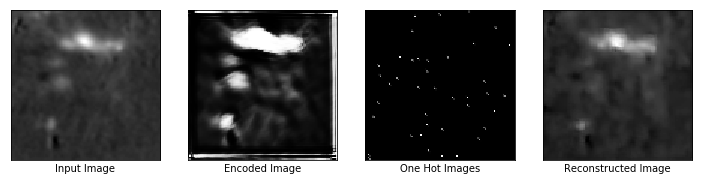

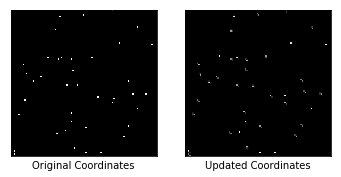

Epochs: 640, Loss: 0.0012320878449827433
Similarity scores: [0.01618529 0.21150188 0.16853432 0.5917339  0.06705173 0.0135937
 0.02178651 0.1247998  0.04156025 0.08072416 0.05168485 0.03418647
 0.0629558  0.13696185 0.60962045 0.9763263  0.15169998 0.00761251
 0.30272064 0.09134585 0.7674566  0.01115111 0.09458317 0.05399995
 0.45677772 0.03127025 0.01877773 0.03869269 0.09218491 0.00179838
 0.04003121 0.1843805  0.20769487 0.17007345 0.02912208 0.03684498
 0.04746096 0.06448831 0.0704808  0.1908244 ]
Updated Coordinates: [[[0.42101362 0.33803865]]]
Gradient min:-0.0005420510424301028, max:0.0004454306326806545



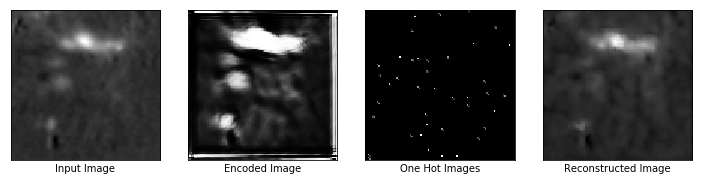

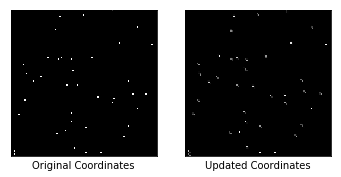

Epochs: 650, Loss: 0.0011544509325176477
Similarity scores: [0.02691606 0.22524014 0.31537044 0.6045999  0.08517498 0.01774511
 0.03414323 0.17614758 0.0607147  0.09965981 0.06755269 0.0471961
 0.08210387 0.16767414 0.6442073  0.96823436 0.19966038 0.01052634
 0.32001358 0.12197366 0.7704676  0.01414853 0.14077659 0.07186949
 0.44134122 0.04868982 0.00953557 0.06628947 0.12712601 0.00343235
 0.06153131 0.22579464 0.32386327 0.18922059 0.05269741 0.05808277
 0.06901106 0.09420397 0.13362129 0.21527052]
Updated Coordinates: [[[0.4209282  0.33801112]]]
Gradient min:-0.0005763403605669737, max:5.939730181125924e-05



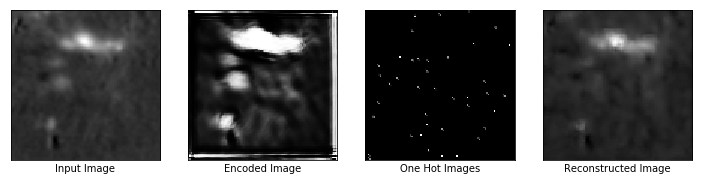

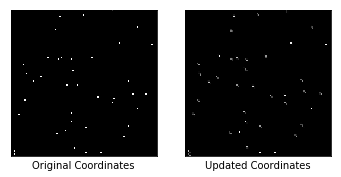

Epochs: 660, Loss: 0.001120148692280054
Similarity scores: [0.02333279 0.22000921 0.38334274 0.61300594 0.08135391 0.00775294
 0.03116497 0.17890082 0.06947794 0.09928238 0.09787454 0.04792744
 0.08215713 0.16508348 0.6472166  0.97213066 0.19791754 0.01264704
 0.33170184 0.10771606 0.8451925  0.02004212 0.14200056 0.06323916
 0.4446065  0.06369955 0.02361438 0.0565147  0.11868268 0.00151716
 0.06219931 0.21816087 0.32492703 0.1928856  0.03472487 0.05588377
 0.06261849 0.09282409 0.0796752  0.21725747]
Updated Coordinates: [[[0.42065945 0.33794364]]]
Gradient min:-0.0005131449433974922, max:7.110867591109127e-05



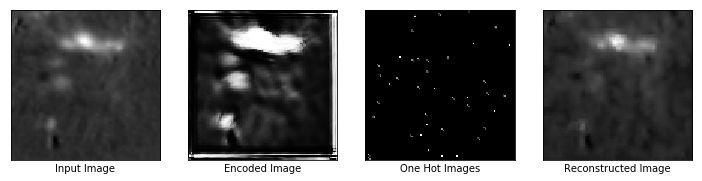

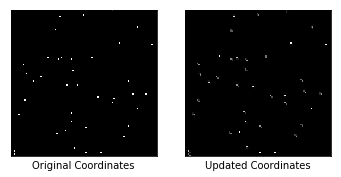

Epochs: 670, Loss: 0.0012284570839256048
Similarity scores: [0.02368129 0.20320222 0.3315526  0.58102846 0.07759492 0.00395254
 0.04646959 0.1583778  0.06494558 0.0871423  0.05895378 0.04544257
 0.0688464  0.14918458 0.6164795  0.9508268  0.17448014 0.00755295
 0.28805757 0.12006821 0.8331372  0.01111032 0.05634567 0.0599228
 0.4594778  0.07631043 0.01016012 0.07145057 0.10933519 0.00568449
 0.0616676  0.23032127 0.32393143 0.1808347  0.03839955 0.04135587
 0.0618507  0.10647053 0.18290576 0.18680122]
Updated Coordinates: [[[0.42045072 0.33783355]]]
Gradient min:-0.00022157907369546592, max:0.0009289548615925014



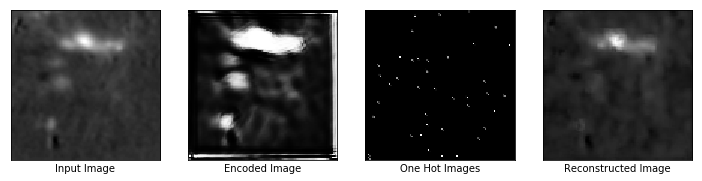

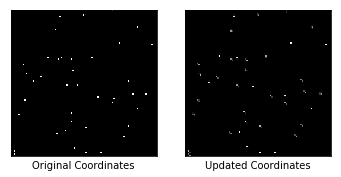

Epochs: 680, Loss: 0.0014391321456059813
Similarity scores: [0.01799379 0.1859859  0.11365641 0.56357086 0.06767302 0.0068863
 0.04975643 0.11272629 0.03752046 0.07943736 0.03526759 0.03596573
 0.0609162  0.13425274 0.5836508  0.96441436 0.148778   0.00853644
 0.29486418 0.07859881 0.7332894  0.01346239 0.05347446 0.06986871
 0.40398282 0.04240225 0.01034531 0.04633743 0.0710646  0.00345672
 0.04074092 0.2124988  0.26492184 0.152731   0.0329775  0.03873527
 0.05367697 0.07590517 0.14847594 0.18230824]
Updated Coordinates: [[[0.4203201  0.33797163]]]
Gradient min:-0.00037367866025306284, max:0.00045562113518826663



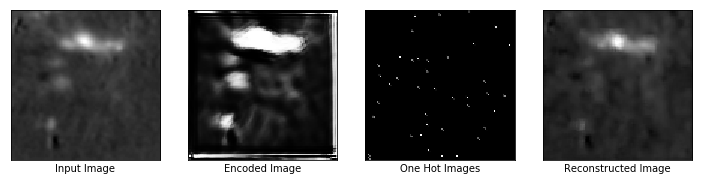

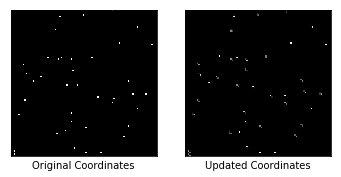

Epochs: 690, Loss: 0.0015804051654413342
Similarity scores: [0.02395245 0.18306533 0.2094213  0.5388313  0.06987628 0.0032097
 0.05799138 0.12060332 0.03691307 0.07053894 0.02555752 0.03085152
 0.05888774 0.12113558 0.6151826  0.9789321  0.14167696 0.00739184
 0.26427543 0.0910953  0.7970466  0.02113435 0.07359462 0.06041033
 0.43454292 0.07909275 0.00642357 0.04506528 0.1172244  0.00530304
 0.0336409  0.19181053 0.26417    0.14452285 0.03095905 0.04104574
 0.05194995 0.07925496 0.157631   0.16644487]
Updated Coordinates: [[[0.4204295  0.33831704]]]
Gradient min:-0.001976235304027796, max:0.00060117500834167



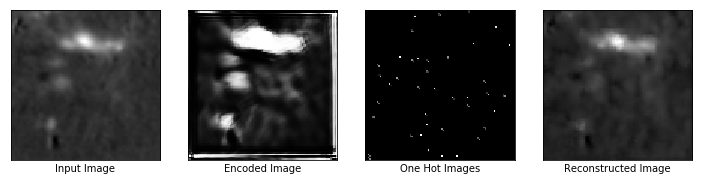

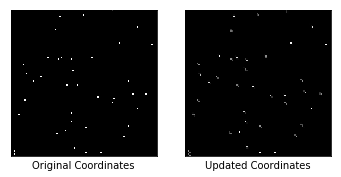

Epochs: 700, Loss: 0.0012745854910463095
Similarity scores: [0.02008902 0.19304258 0.24046828 0.57038593 0.08435487 0.00550648
 0.05744639 0.13426936 0.03643892 0.08378301 0.02916919 0.04081419
 0.07322056 0.13733976 0.6153858  0.9711485  0.17388855 0.00620283
 0.30719292 0.10697111 0.8400067  0.02198861 0.06777483 0.07087263
 0.45325372 0.08486912 0.00698061 0.06138757 0.1149086  0.00646846
 0.03642515 0.23500594 0.3332469  0.15694389 0.03883931 0.04532737
 0.06382054 0.10421642 0.16057642 0.18548314]
Updated Coordinates: [[[0.42043346 0.3384414 ]]]
Gradient min:-0.0012121028266847134, max:0.0007071800646372139



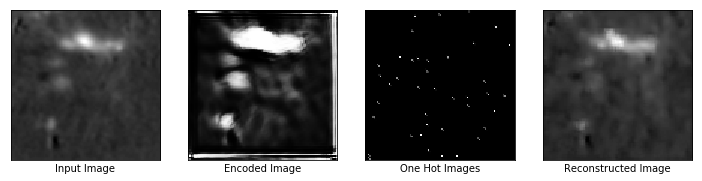

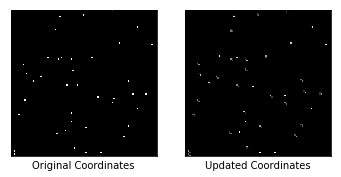

Epochs: 710, Loss: 0.001257666852325201
Similarity scores: [0.0212275  0.18849346 0.24569356 0.550819   0.07981771 0.01350645
 0.0585852  0.13618049 0.03605518 0.0767877  0.02380141 0.04318693
 0.07198061 0.13912994 0.60514027 0.97552633 0.15775958 0.00619273
 0.30547497 0.10072194 0.7882386  0.0113959  0.06970415 0.07533677
 0.45812705 0.05051647 0.00537596 0.0474421  0.10403556 0.00456696
 0.03801414 0.2218757  0.2936533  0.15819463 0.03649403 0.05739513
 0.06307449 0.0827902  0.11143305 0.17489715]
Updated Coordinates: [[[0.4204783  0.33846274]]]
Gradient min:-0.0008980814018286765, max:0.0005965507007203996



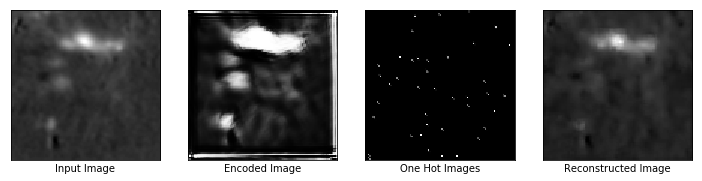

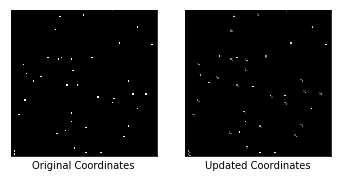

Epochs: 720, Loss: 0.0010654870420694351
Similarity scores: [0.02701874 0.20011665 0.19579206 0.5521579  0.08402254 0.00713129
 0.05618062 0.16329223 0.05864757 0.09244195 0.03201781 0.04621876
 0.07542675 0.15291147 0.6309719  0.97053176 0.16792902 0.00620258
 0.31196898 0.14733689 0.8141524  0.01737849 0.06835185 0.08447356
 0.4471334  0.06148965 0.00938922 0.0675303  0.13212575 0.00919514
 0.05435648 0.2113823  0.31416067 0.16565937 0.04250182 0.06119638
 0.06733691 0.10404674 0.152745   0.20071454]
Updated Coordinates: [[[0.4203153  0.33817792]]]
Gradient min:-0.000650158035568893, max:0.0007204744615592062



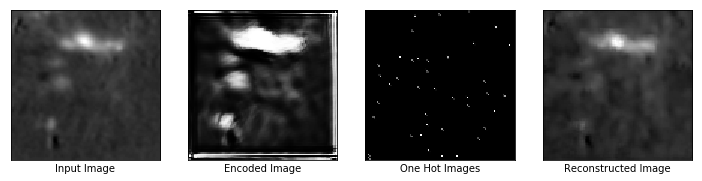

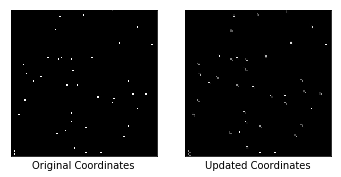

Epochs: 730, Loss: 0.0014170337235555053
Similarity scores: [0.02890935 0.1911142  0.13628094 0.520271   0.08912708 0.00747848
 0.07361085 0.15166773 0.06057646 0.08614802 0.04412784 0.04560836
 0.07902731 0.15129437 0.5723184  0.9636935  0.17483301 0.00601003
 0.30547675 0.1491424  0.8173152  0.00770974 0.06579418 0.08232698
 0.45552394 0.03236435 0.00635865 0.06237626 0.14644259 0.00813348
 0.04362479 0.24490988 0.3111504  0.15077901 0.04653794 0.07143942
 0.06969283 0.1011981  0.1358354  0.19267826]
Updated Coordinates: [[[0.42028493 0.33825484]]]
Gradient min:-0.0013522844528779387, max:0.0007659232942387462



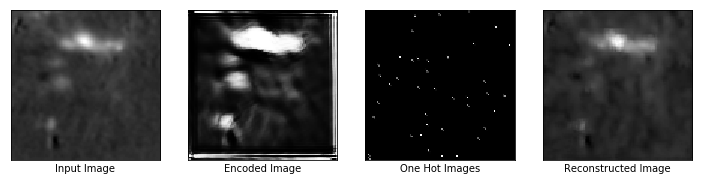

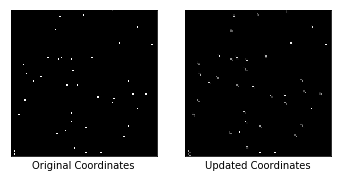

Epochs: 740, Loss: 0.0012164381332695484
Similarity scores: [0.0258564  0.20277573 0.3435451  0.52651566 0.07794455 0.01639845
 0.05939017 0.12877029 0.04791725 0.07541898 0.04735584 0.04073514
 0.06650529 0.13882867 0.5816959  0.9599414  0.16807447 0.01270946
 0.27730608 0.099429   0.8242752  0.00520526 0.07711837 0.07358977
 0.46267876 0.01897035 0.00531655 0.05534348 0.1238967  0.00698348
 0.04798288 0.22645125 0.26933652 0.15011932 0.03489612 0.05362582
 0.06581815 0.09141908 0.11509617 0.1713973 ]
Updated Coordinates: [[[0.421207   0.33896238]]]
Gradient min:-0.0008277602610178292, max:0.0004801610193680972



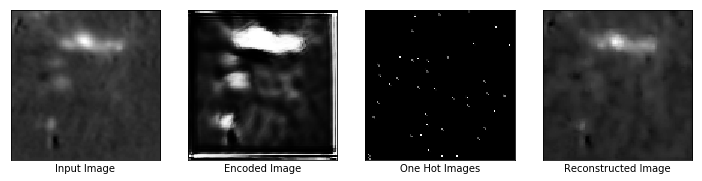

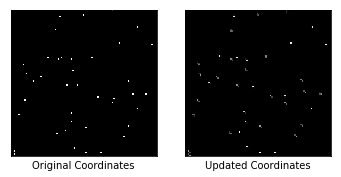

Epochs: 750, Loss: 0.0012014997191727161
Similarity scores: [0.0236658  0.19605853 0.2742482  0.5085419  0.07627022 0.00412016
 0.05276427 0.15233801 0.05621675 0.07690916 0.02425164 0.03657457
 0.06503157 0.12367123 0.62019336 0.9693718  0.1401633  0.00529509
 0.28444365 0.1029062  0.7403014  0.01997317 0.04316796 0.06696469
 0.35274625 0.06272356 0.0042195  0.0561612  0.08458044 0.00514517
 0.04872689 0.19424179 0.27078697 0.16003992 0.03844187 0.04270258
 0.05894157 0.09012584 0.16010042 0.18502304]
Updated Coordinates: [[[0.4214213 0.3389524]]]
Gradient min:-0.0010792764369398355, max:0.0005289928521960974



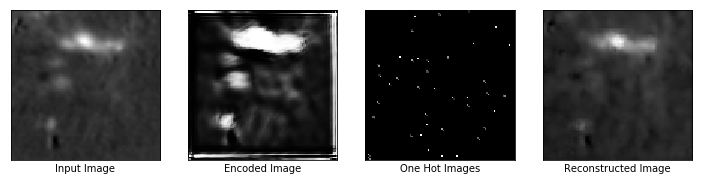

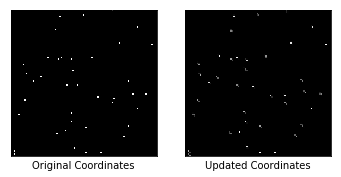

Epochs: 760, Loss: 0.001422954024747014
Similarity scores: [0.02492184 0.21553174 0.15983404 0.5187883  0.09298079 0.00861852
 0.05868827 0.15343833 0.05427344 0.0857386  0.02321829 0.04700294
 0.07892688 0.14117715 0.63099784 0.9714006  0.1574336  0.00787353
 0.31715277 0.12301477 0.75051343 0.03001096 0.07813767 0.07913376
 0.3747445  0.09222882 0.00536748 0.05140177 0.11858335 0.00542105
 0.0431488  0.20356897 0.28902406 0.17023514 0.04944362 0.05558628
 0.07389055 0.08521388 0.14081012 0.19917297]
Updated Coordinates: [[[0.4208881 0.338738 ]]]
Gradient min:-0.0014974158257246017, max:0.0013335036346688867



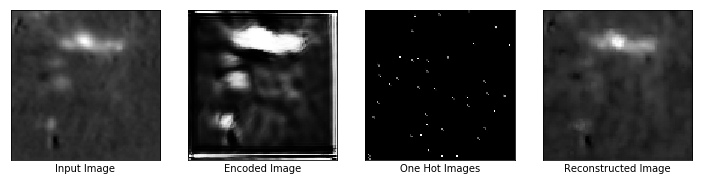

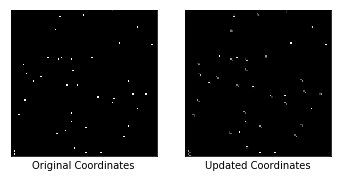

Epochs: 770, Loss: 0.0012210813583806157
Similarity scores: [0.02461489 0.18240912 0.26449034 0.49199113 0.09208578 0.01613484
 0.05341078 0.15241073 0.0408469  0.0831795  0.03455758 0.04439678
 0.07639997 0.13470839 0.6044789  0.97167057 0.16096249 0.00645038
 0.27745414 0.13854936 0.76437575 0.00872175 0.09277935 0.09462615
 0.39736065 0.04117256 0.00549369 0.05136221 0.12749605 0.01261308
 0.04468276 0.17752543 0.29397905 0.14883283 0.04798798 0.05710159
 0.07312284 0.08696043 0.10876592 0.17776555]
Updated Coordinates: [[[0.42059994 0.33862203]]]
Gradient min:-0.0012169501278549433, max:0.0007744496106170118



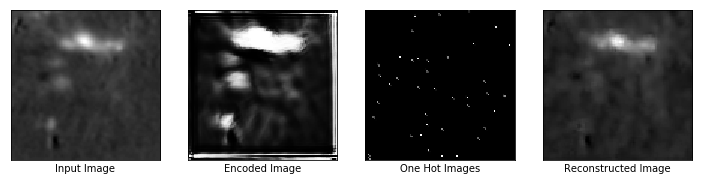

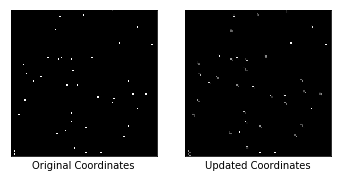

Epochs: 780, Loss: 0.001043151831254363
Similarity scores: [0.02406878 0.2067135  0.23123711 0.4856709  0.08417423 0.00734688
 0.06425304 0.13837396 0.03305009 0.07772582 0.01902402 0.03882922
 0.06767303 0.12426373 0.6095142  0.9624062  0.1441691  0.007316
 0.26572    0.11713924 0.85451937 0.00869013 0.07298838 0.08231934
 0.41940796 0.04359575 0.00510688 0.05360587 0.13494647 0.00816212
 0.03935464 0.1846245  0.25650617 0.14617874 0.04185737 0.04475542
 0.066099   0.08590686 0.10458298 0.17643489]
Updated Coordinates: [[[0.42049667 0.33870974]]]
Gradient min:-0.0005259808385744691, max:0.0006255723419599235



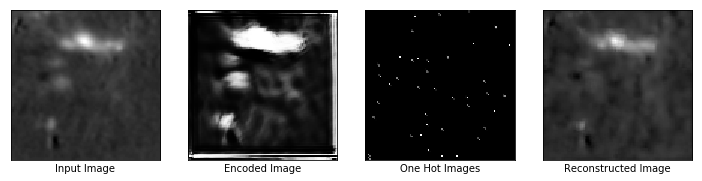

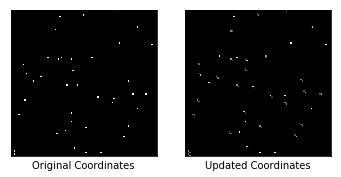

Epochs: 790, Loss: 0.0015199007466435432
Similarity scores: [0.01906822 0.18578424 0.46943885 0.48198137 0.08504844 0.00645655
 0.05403126 0.15485512 0.03999048 0.07510561 0.01777578 0.04728352
 0.07933787 0.1169126  0.6131479  0.9758698  0.13634443 0.00814182
 0.30050057 0.10656301 0.7977628  0.01432236 0.03870414 0.04982554
 0.38088623 0.06922757 0.0023684  0.04196687 0.1036035  0.00238963
 0.02737781 0.19391611 0.23524295 0.15672508 0.03974854 0.04655734
 0.06734437 0.07683944 0.11695087 0.18214248]
Updated Coordinates: [[[0.42082947 0.33870602]]]
Gradient min:-0.0013113042805343866, max:0.00014155502140056342



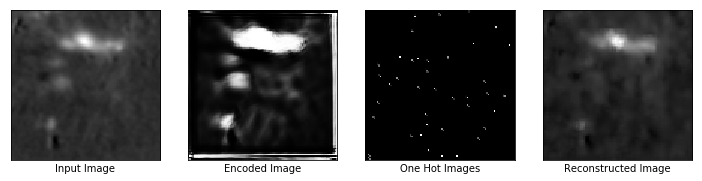

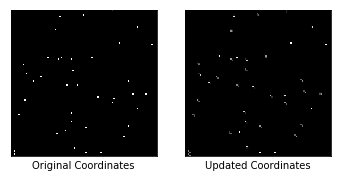

Epochs: 800, Loss: 0.001128281350247562
Similarity scores: [0.01828202 0.19703442 0.2193598  0.49291953 0.06406438 0.00586371
 0.04481183 0.10553464 0.0339266  0.06226391 0.01380902 0.02792856
 0.04940266 0.10197232 0.5675716  0.97730106 0.12111087 0.00597207
 0.25296667 0.06914455 0.8129027  0.01651654 0.02992358 0.05525018
 0.39611122 0.08859809 0.0070074  0.03540562 0.09080296 0.00561136
 0.02868477 0.15405717 0.2321308  0.12710378 0.02860963 0.03448364
 0.04887682 0.06365816 0.09918613 0.15655915]
Updated Coordinates: [[[0.42091897 0.3386432 ]]]
Gradient min:-0.0006983989733271301, max:0.0006593187572434545



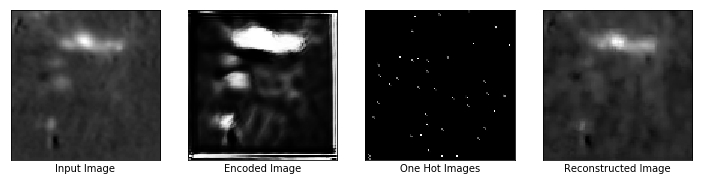

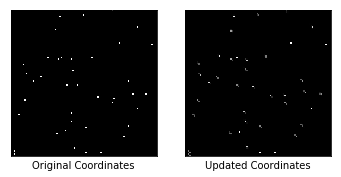

Epochs: 810, Loss: 0.0011672177352011204
Similarity scores: [0.01638988 0.18076429 0.29062963 0.47649533 0.05854819 0.00961746
 0.05590696 0.11894397 0.0351597  0.05968813 0.01232931 0.02561686
 0.04416406 0.09655177 0.57907146 0.98247594 0.11973559 0.00458057
 0.24167939 0.07910326 0.7710781  0.01042615 0.03938175 0.05954726
 0.42185932 0.05716204 0.00307734 0.03710238 0.09240858 0.00880315
 0.02959909 0.17014259 0.21986793 0.13983539 0.02534324 0.03388778
 0.04116328 0.06556423 0.10290721 0.15747288]
Updated Coordinates: [[[0.4206527  0.33850348]]]
Gradient min:-0.001007117796689272, max:0.000555171282030642



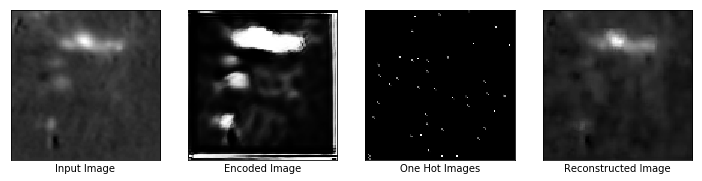

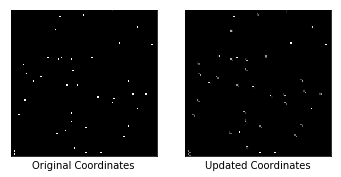

Epochs: 820, Loss: 0.0016440826002508402
Similarity scores: [0.00928678 0.16155165 0.29592738 0.48948726 0.03781892 0.01070522
 0.02965883 0.09392975 0.02540086 0.03334811 0.01084344 0.01573344
 0.02640696 0.07114805 0.5187441  0.98231137 0.09420372 0.0016191
 0.20704283 0.04463838 0.71306026 0.01123445 0.03102451 0.03285239
 0.45552194 0.05000158 0.00292171 0.02104476 0.03725745 0.0035559
 0.01769146 0.15049715 0.17901155 0.10447008 0.01561405 0.01615181
 0.02864185 0.0365376  0.05481984 0.10769142]
Updated Coordinates: [[[0.4204087  0.33838403]]]
Gradient min:-0.0020355444867163897, max:0.0008409289875999093



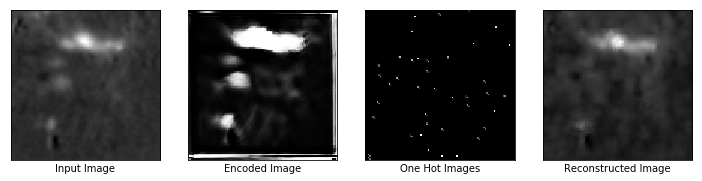

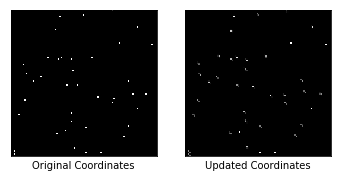

Epochs: 830, Loss: 0.001574537716805935
Similarity scores: [9.2624184e-03 1.4175841e-01 4.7669509e-01 4.4595796e-01 4.0437706e-02
 2.0345360e-02 3.0161383e-02 8.3167784e-02 1.6542818e-02 3.8357414e-02
 3.9412975e-03 1.6175512e-02 2.8235270e-02 7.1008883e-02 5.3242964e-01
 9.9519336e-01 8.3671495e-02 2.5927413e-03 1.7542733e-01 4.0105283e-02
 6.7814058e-01 2.3463594e-02 1.6788924e-02 3.1894635e-02 4.2925572e-01
 1.4425175e-01 8.8058936e-04 1.7540928e-02 7.8716166e-02 2.4527833e-03
 1.4286716e-02 1.4040145e-01 1.5577932e-01 1.1811204e-01 1.5467827e-02
 1.9756977e-02 2.9122561e-02 3.5123248e-02 4.7550604e-02 1.2082751e-01]
Updated Coordinates: [[[0.4207327  0.33867973]]]
Gradient min:-0.0011412958847358823, max:0.0010963368695229292



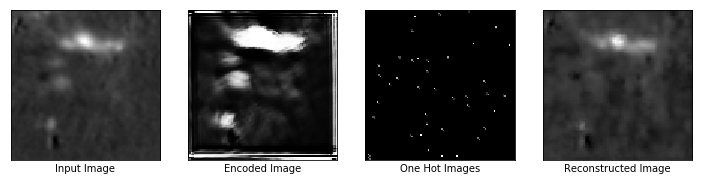

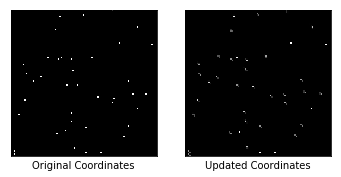

Epochs: 840, Loss: 0.002543994225561619
Similarity scores: [0.03011921 0.17945644 0.6376543  0.46089363 0.05847941 0.01116137
 0.07001574 0.13880801 0.06638144 0.05411513 0.0262838  0.03396031
 0.04236632 0.09341117 0.616391   0.9621894  0.13951834 0.02470071
 0.19016755 0.17595708 0.70597005 0.00649552 0.02657166 0.04426308
 0.44033423 0.04754915 0.00126834 0.05763422 0.15033704 0.00504097
 0.04789833 0.20478755 0.22822851 0.17442587 0.03868184 0.03292951
 0.04777074 0.1132955  0.19694303 0.14745969]
Updated Coordinates: [[[0.42072123 0.33854106]]]
Gradient min:-0.0014898496447131038, max:0.0029557531233876944



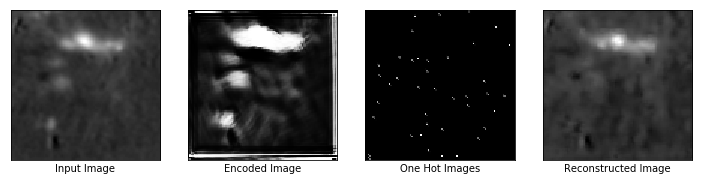

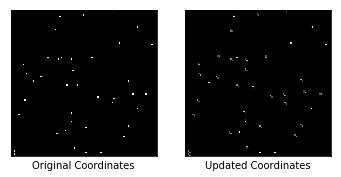

Epochs: 850, Loss: 0.0014059004606679082
Similarity scores: [2.79124677e-02 1.85526088e-01 6.63906455e-01 4.02927309e-01
 7.42769465e-02 1.42328581e-02 6.60929382e-02 1.90340266e-01
 6.10885397e-02 6.98400363e-02 3.37910093e-02 3.90568450e-02
 6.36752397e-02 9.42173302e-02 6.22061193e-01 9.28751826e-01
 1.39782578e-01 2.11711880e-02 2.11633846e-01 1.89333424e-01
 6.48409784e-01 4.16496173e-02 3.80034894e-02 4.09662835e-02
 4.37659144e-01 1.30268767e-01 1.25878816e-03 6.59836382e-02
 1.57718375e-01 7.29737978e-04 4.19587046e-02 2.50914305e-01
 3.71277988e-01 1.90195203e-01 2.83070207e-02 3.72816697e-02
 5.36982827e-02 1.29678041e-01 1.05587974e-01 1.77465215e-01]
Updated Coordinates: [[[0.4206393  0.33831987]]]
Gradient min:-0.00046930945245549083, max:0.0011851891176775098



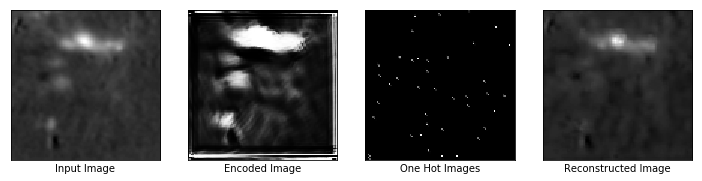

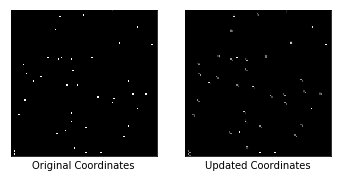

Epochs: 860, Loss: 0.0011631518136709929
Similarity scores: [0.02805547 0.21814871 0.59633905 0.43028656 0.08092155 0.01678259
 0.0764029  0.1912026  0.06805364 0.074314   0.01793464 0.0472676
 0.07603935 0.10908686 0.62316954 0.9500409  0.1265305  0.03369211
 0.2518069  0.21084043 0.6090541  0.03061413 0.05397752 0.08517466
 0.4754238  0.1449987  0.00147213 0.07126816 0.20216486 0.00547461
 0.04301037 0.2296346  0.31552204 0.21733895 0.03807415 0.04437432
 0.06394857 0.13792753 0.15242228 0.19099241]
Updated Coordinates: [[[0.42056975 0.33804336]]]
Gradient min:-0.0006795587833039463, max:0.00015890174836385995



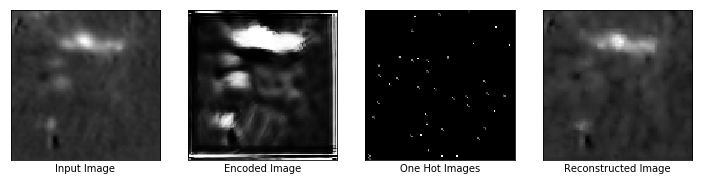

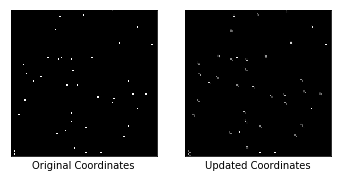

Epochs: 870, Loss: 0.0011169322533532977
Similarity scores: [0.02193719 0.2576724  0.64150774 0.44511053 0.07804234 0.02179249
 0.07412498 0.19366947 0.05940811 0.07001065 0.02807293 0.05075551
 0.07827192 0.11381464 0.59587353 0.9608355  0.16053091 0.02738484
 0.2552611  0.15046349 0.6227301  0.03979455 0.04797832 0.04395574
 0.4537067  0.16376711 0.0018492  0.06225461 0.16498591 0.00286233
 0.04652145 0.2231045  0.29577097 0.23049983 0.04329079 0.05435304
 0.06413785 0.1199083  0.09038254 0.20967986]
Updated Coordinates: [[[0.42103076 0.33830646]]]
Gradient min:-0.0007489146082662046, max:0.00014806786202825606



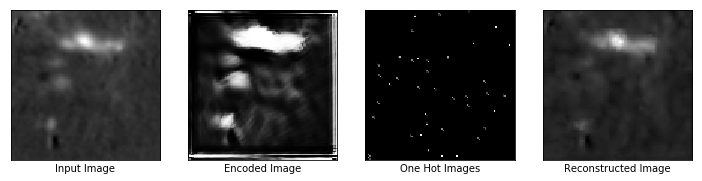

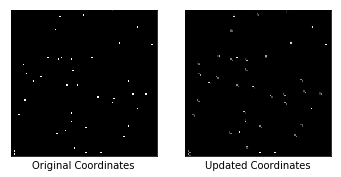

Epochs: 880, Loss: 0.001073202583938837
Similarity scores: [0.02723774 0.21611151 0.59914464 0.46978486 0.08049558 0.02545627
 0.05626743 0.17539352 0.05822348 0.07481937 0.02246071 0.04554769
 0.06852396 0.11328108 0.5701455  0.96928483 0.14047025 0.02063093
 0.26023617 0.09638616 0.6356605  0.03846512 0.06097716 0.06103751
 0.49850756 0.1762826  0.00534527 0.05996982 0.11809749 0.00200897
 0.04022796 0.23250258 0.26385266 0.23230195 0.04009065 0.04816742
 0.06111606 0.09894844 0.08171362 0.1805419 ]
Updated Coordinates: [[[0.42076206 0.33840325]]]
Gradient min:-0.0007818500744178891, max:0.00020937203953508288



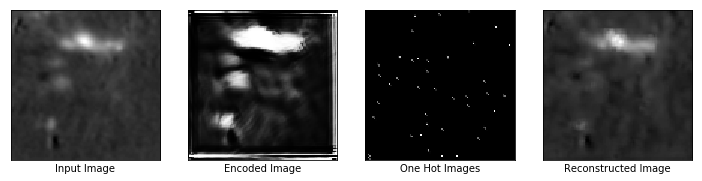

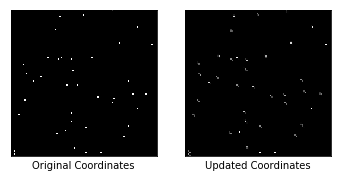

Epochs: 890, Loss: 0.0010031808633357286
Similarity scores: [0.0252728  0.17320085 0.6746833  0.4752735  0.06427039 0.02706091
 0.0676083  0.16882293 0.05706075 0.06110119 0.02572037 0.03323509
 0.05481994 0.10343868 0.55553687 0.92965    0.1303386  0.01599222
 0.23665853 0.14781518 0.64476097 0.024105   0.07082675 0.05480141
 0.47202176 0.15922348 0.00629042 0.0564345  0.14861327 0.00245177
 0.03958466 0.20425177 0.29631954 0.18513405 0.0291431  0.0332747
 0.05046564 0.11718044 0.10080847 0.15507413]
Updated Coordinates: [[[0.42059022 0.3385466 ]]]
Gradient min:-0.0006780368858017027, max:0.00019065015658270568



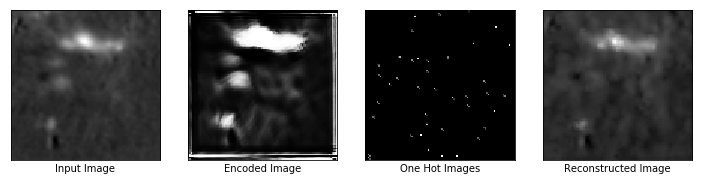

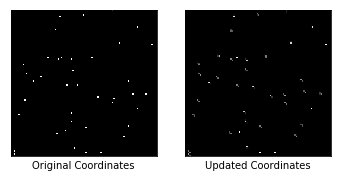

Epochs: 900, Loss: 0.001195293152704835
Similarity scores: [0.01859602 0.21597879 0.7452451  0.38210058 0.07152656 0.01789091
 0.07261215 0.15915239 0.03902471 0.06506618 0.01857075 0.0438995
 0.06428421 0.11028088 0.5473418  0.9800872  0.12203826 0.01635445
 0.22803983 0.1058078  0.54639274 0.01163651 0.02482695 0.04310812
 0.41470894 0.14038177 0.00175041 0.04500314 0.16332318 0.00296412
 0.03817682 0.17473346 0.20568813 0.21298915 0.04013727 0.04589324
 0.0611756  0.08400023 0.08474641 0.18432479]
Updated Coordinates: [[[0.42064604 0.33869028]]]
Gradient min:-0.0004656771197915077, max:6.907297938596457e-05



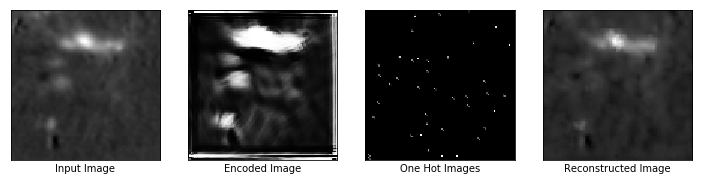

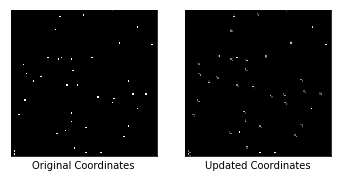

Epochs: 910, Loss: 0.0010294211097061634
Similarity scores: [0.02485127 0.23070283 0.6227937  0.44618005 0.08113688 0.04410048
 0.08071958 0.16973308 0.04513717 0.07607533 0.0222073  0.0482248
 0.07384522 0.11460989 0.5906447  0.96480584 0.13814433 0.01849615
 0.25737464 0.14446743 0.6365945  0.01566485 0.0749852  0.064695
 0.46225747 0.12289878 0.00299302 0.05731557 0.13536887 0.0039339
 0.03662719 0.19690894 0.2703926  0.2182157  0.03857452 0.05596887
 0.0658294  0.11183256 0.10268676 0.18854466]
Updated Coordinates: [[[0.42109197 0.33867264]]]
Gradient min:-0.0006137110758572817, max:0.00039721225039102137



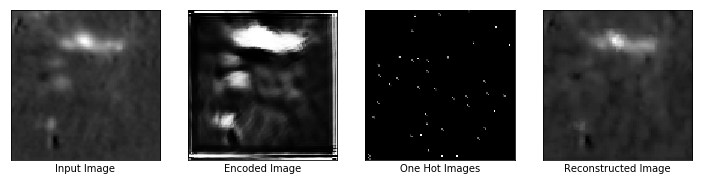

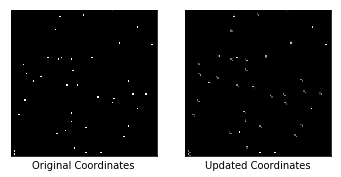

Epochs: 920, Loss: 0.0010784331243485212
Similarity scores: [0.02270632 0.19364026 0.6644149  0.41881567 0.07503116 0.04630684
 0.09267996 0.17076272 0.04915925 0.06802826 0.02122226 0.04131535
 0.06772604 0.10536496 0.5678241  0.96836513 0.13189629 0.02776047
 0.24214596 0.12136787 0.5906845  0.02744097 0.0623236  0.06406043
 0.43256873 0.18237592 0.0034038  0.05833063 0.13555844 0.00367363
 0.04012127 0.17309989 0.24262774 0.19657424 0.0345034  0.05547899
 0.06077194 0.11030006 0.09720894 0.16641432]
Updated Coordinates: [[[0.42080674 0.33840486]]]
Gradient min:-0.00034671707544475794, max:0.00026958537637256086



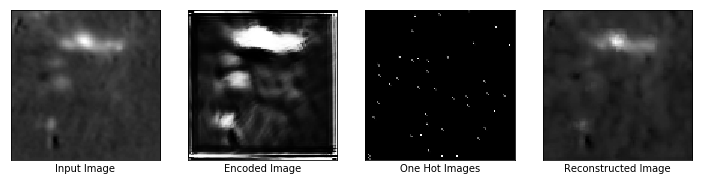

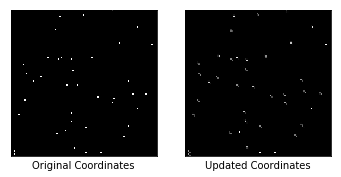

Epochs: 930, Loss: 0.0010806166101247072
Similarity scores: [0.02140985 0.22330777 0.6306007  0.45243934 0.06739519 0.02755633
 0.07235693 0.17535381 0.05145252 0.06931245 0.02751267 0.03899311
 0.06324254 0.11375111 0.5586728  0.9678256  0.13127093 0.03009325
 0.2423296  0.1402941  0.5806039  0.00759431 0.05577086 0.04179403
 0.4481325  0.10082597 0.0042848  0.06445791 0.15604937 0.00444037
 0.04431843 0.19439322 0.27647105 0.22606221 0.03084601 0.04842034
 0.05435969 0.11799022 0.09447463 0.17562458]
Updated Coordinates: [[[0.42143008 0.33877376]]]
Gradient min:-0.0015590389957651496, max:0.0009804483270272613



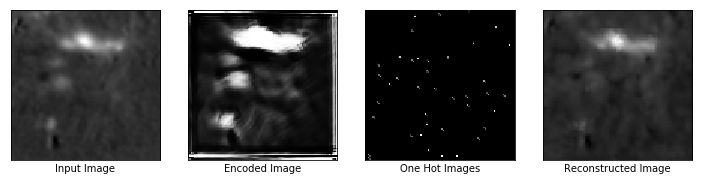

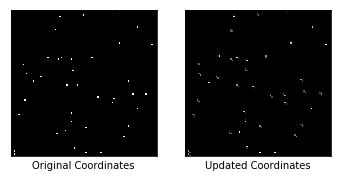

Epochs: 940, Loss: 0.0009649591520428658
Similarity scores: [0.02518393 0.20072627 0.62865794 0.45795482 0.07033943 0.03936478
 0.06932048 0.17976682 0.05417049 0.07017267 0.02924906 0.04359192
 0.06298287 0.11132307 0.5768857  0.9703824  0.15109235 0.01717755
 0.25026333 0.16349642 0.5643768  0.0076403  0.06206476 0.04293347
 0.47544292 0.06330309 0.0025878  0.06651319 0.14684615 0.00402112
 0.05139919 0.2018028  0.29708195 0.2146387  0.0352343  0.04874352
 0.0515036  0.12634555 0.12735367 0.1741682 ]
Updated Coordinates: [[[0.42214122 0.33902574]]]
Gradient min:-0.0006436000694520772, max:0.0006336655933409929



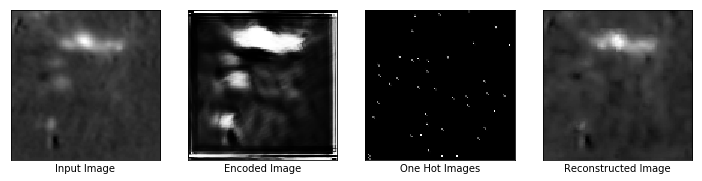

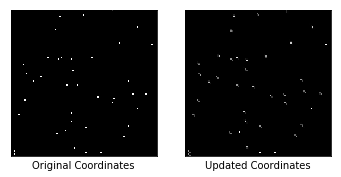

Epochs: 950, Loss: 0.0012538161827251315
Similarity scores: [0.02046573 0.20190728 0.7942362  0.48810312 0.05918242 0.02329628
 0.05564987 0.16588087 0.04945162 0.0587683  0.03045582 0.03670724
 0.05053103 0.09792038 0.5913468  0.95996153 0.14419827 0.02173476
 0.2199844  0.1358648  0.5039598  0.02107794 0.07536671 0.05513236
 0.4286796  0.06315761 0.00455397 0.05397214 0.10959049 0.00510481
 0.03318293 0.20871556 0.2711958  0.20122989 0.03801598 0.0326778
 0.05063169 0.10855269 0.07333993 0.16779938]
Updated Coordinates: [[[0.4220684  0.33913726]]]
Gradient min:-0.0005689494428224862, max:0.000757983943913132



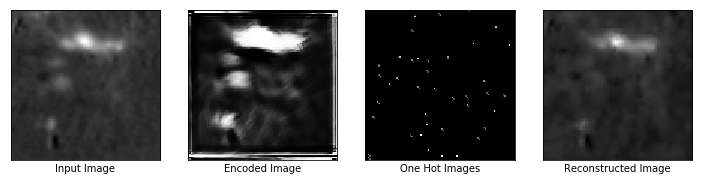

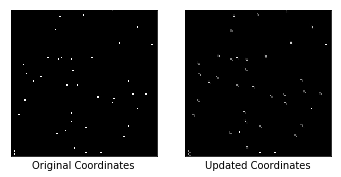

Epochs: 960, Loss: 0.0010474357986822724
Similarity scores: [0.02626944 0.22070673 0.5876313  0.4286231  0.07229836 0.0179959
 0.10967742 0.18241632 0.05681411 0.06991481 0.02017133 0.04893976
 0.06923745 0.10618412 0.60595495 0.95834696 0.13619983 0.0292844
 0.2438729  0.15096352 0.44219854 0.01658321 0.03525054 0.04474125
 0.4154349  0.1160272  0.00240439 0.07105581 0.14308603 0.00364269
 0.0447396  0.19850598 0.2747085  0.24351665 0.04152326 0.04966788
 0.05740761 0.13558464 0.1329152  0.1862403 ]
Updated Coordinates: [[[0.42240292 0.33846444]]]
Gradient min:-0.0003718218649737537, max:7.383857882814482e-05



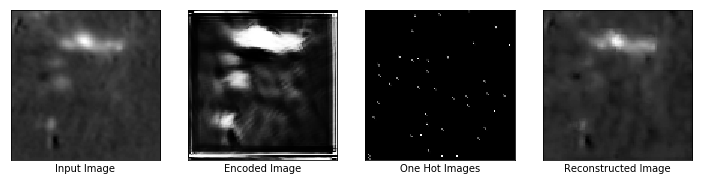

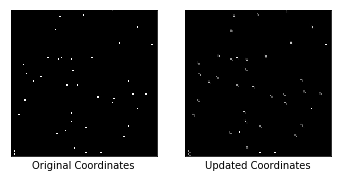

Epochs: 970, Loss: 0.0011241628089919686
Similarity scores: [0.02449345 0.2196286  0.65547323 0.4994956  0.06603916 0.01043086
 0.08320618 0.2013774  0.06874364 0.06902301 0.04226613 0.0402716
 0.06262916 0.10580824 0.6019291  0.95555586 0.14096285 0.02637885
 0.23772097 0.18439443 0.59453946 0.0182982  0.07240934 0.058484
 0.48486373 0.09942731 0.00335712 0.07554039 0.1700096  0.00332037
 0.05165233 0.22808576 0.34442365 0.24149595 0.03189843 0.03806084
 0.051418   0.14841107 0.09205844 0.17988737]
Updated Coordinates: [[[0.4224571  0.33849332]]]
Gradient min:-0.0009055297705344856, max:0.0008585043251514435



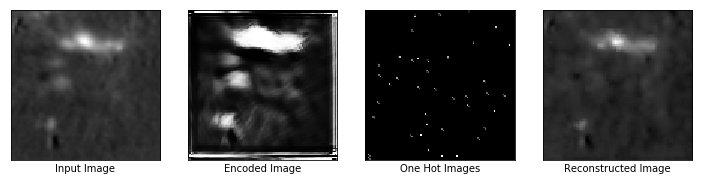

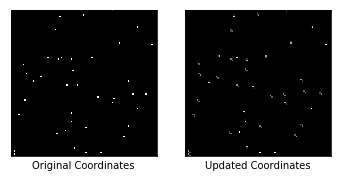

Epochs: 980, Loss: 0.0011394349858164787
Similarity scores: [0.02616859 0.22655338 0.63323665 0.44503245 0.07831807 0.01627141
 0.08667013 0.19009346 0.06866225 0.0788857  0.02054888 0.05269794
 0.07612347 0.11405653 0.6118519  0.9539381  0.16402367 0.0359248
 0.2557989  0.14460488 0.5965714  0.02015998 0.04534271 0.05767808
 0.4606104  0.1464428  0.00541703 0.07114958 0.15677229 0.00347599
 0.04632734 0.20565271 0.25733346 0.26443952 0.04945525 0.05348606
 0.06710313 0.13997327 0.13037069 0.19058406]
Updated Coordinates: [[[0.42264843 0.33863094]]]
Gradient min:-0.0006958321901038289, max:0.0005296959425322711



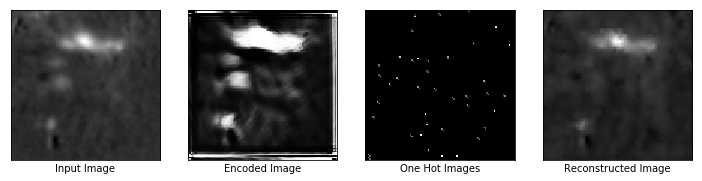

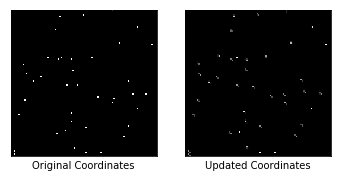

Epochs: 990, Loss: 0.0012801536358892918
Similarity scores: [0.021879   0.20373745 0.37686586 0.47350952 0.08254015 0.01954075
 0.09318782 0.14003502 0.04677834 0.07250524 0.01872602 0.04728864
 0.06566287 0.09946531 0.5725179  0.97123724 0.13832048 0.01565245
 0.24537055 0.11141352 0.5523919  0.01358205 0.05804806 0.07233259
 0.46116364 0.09653787 0.00444794 0.05638368 0.1618477  0.00174116
 0.03532728 0.1813196  0.25727898 0.21887608 0.04034203 0.04651206
 0.06399457 0.11575425 0.08783714 0.17335965]
Updated Coordinates: [[[0.42272484 0.33850694]]]
Gradient min:-0.0005711995763704181, max:0.0012362712295725942



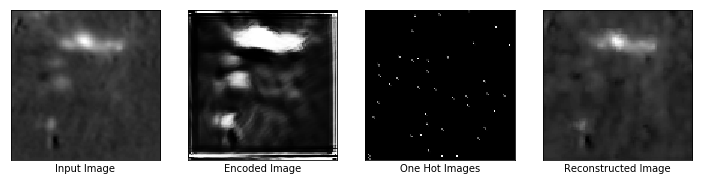

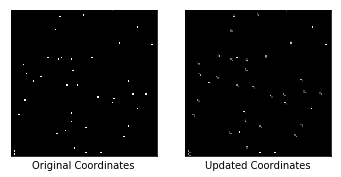

Epochs: 1000, Loss: 0.0010235127992928028
Similarity scores: [0.02086714 0.20482035 0.57324463 0.41119233 0.07597203 0.01196364
 0.10129804 0.14480032 0.03707058 0.06370544 0.02232543 0.04420733
 0.0632892  0.09679357 0.51201475 0.9752244  0.12881163 0.02590636
 0.23634629 0.10262254 0.5036899  0.01142172 0.03880643 0.06102082
 0.44076848 0.09125068 0.00186925 0.0472154  0.17383116 0.00235929
 0.03445856 0.1716156  0.2362802  0.22819458 0.04196062 0.05102985
 0.06435061 0.10087938 0.12508126 0.17270541]
Updated Coordinates: [[[0.42252275 0.33858982]]]
Gradient min:-0.00043977750465273857, max:0.00028604528051801026


In [14]:
from utils_vis import plot_comparison

BATCH_SIZE = 8
MAX_EPOCHS = 1000
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model  = train_fn(batched_imgs, coords, img_size, BATCH_SIZE)
    #loss is append for each epochs
    loss_list.append(loss)
    if epochs%10==0:
        img_row01 = [batched_imgs[0], encoder_output[0], stack4plot(one_hot_imgs), reconstruction[0]]
        img_row02 = [stack4plot(ori_one_hot_imgs), stack4plot(one_hot_imgs)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Loss: {}".format(epochs, loss.numpy()))
        print("Similarity scores: {}".format(similarity_score[0]))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient min:{}, max:{}".format(np.min(grad_model[0]), np.max(grad_model[0])))
    #append list for every 100 epochs 
    if epochs%100==0:
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1